# Previsione della Qualità dell'Aria - **Allenamento e Valutazione dei Modelli India**

## Caricamento dei Datasets ed Import Librerie



In [1]:
!pip install pykan

In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import json
import inspect
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import types
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    ParameterSampler
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn.utils.prune as prune
from torch.nn.functional import softmax

%pip install xgboost
import xgboost as xgb
from kan import *

N_JOBS = -1
RANDOM_STATE = 42

Note: you may need to restart the kernel to use updated packages.


In [4]:
github_url = 'https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/original_india_dataset.csv'
local_path = '/scratch.hpc/martin.tomassi/datasets_pm'
local_file = os.path.join(local_path, 'original_india_dataset.csv')

if not os.path.exists(local_path):
    os.makedirs(local_path)

if not os.path.exists(local_file):
    df = pd.read_csv(github_url,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)
    df.to_csv(local_file, index=False)
    print("File scaricato e salvato in locale.")
else:
    print("Il file esiste già in locale, lo carico...")
    df = pd.read_csv(local_file,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)

obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("category")
df.drop('date', axis=1, inplace=True)
df = df[(df['year'] >= 2018)]
df = df.reset_index(drop=True)
df.head()

File scaricato e salvato in locale.


,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,pm_lag_1D,co_lag_1D,o3_lag_1D,pm_lag_2D,co_lag_2D,o3_lag_2D,pm_lag_3D,co_lag_3D,o3_lag_3D,Class
0,2018,1,1,Bihar,248.338542,1.253194,25.368750,0,1,1,...,205.467292,1.088611,23.453125,265.163333,1.719167,12.699167,234.609375,1.699861,11.677917,6
1,2018,1,1,Odisha,48.950000,3.310000,0.020000,0,1,1,...,48.950000,3.310000,0.020000,48.950000,3.447083,0.020000,48.950000,3.357083,0.015000,3
2,2018,1,1,West Bengal,11.015000,0.985417,13.758958,0,1,1,...,11.015000,1.000833,14.120625,11.015000,0.877500,12.428333,11.015000,1.125000,12.632708,2
3,2018,1,1,Andhra Pradesh,53.847778,0.723542,51.598333,0,1,1,...,51.303542,0.657500,49.261250,50.059861,0.672188,43.236424,56.092118,0.733437,43.451597,3
4,2018,1,1,Gujarat,84.484167,0.863750,44.890000,0,1,1,...,83.526250,0.887500,64.475833,81.357083,1.103750,51.791667,85.548750,1.254167,56.731667,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43961 entries, 0 to 43960
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        43961 non-null  int64   
 1   month       43961 non-null  int64   
 2   dayofmonth  43961 non-null  int64   
 3   state       43961 non-null  category
 4   PM2.5       43961 non-null  float64 
 5   CO          43961 non-null  float64 
 6   O3          43961 non-null  float64 
 7   dayofweek   43961 non-null  int64   
 8   quarter     43961 non-null  int64   
 9   weekofyear  43961 non-null  int64   
 10  dayofyear   43961 non-null  int64   
 11  pm_lag_1Y   38402 non-null  float64 
 12  co_lag_1Y   38402 non-null  float64 
 13  o3_lag_1Y   38402 non-null  float64 
 14  pm_lag_2Y   32899 non-null  float64 
 15  co_lag_2Y   32899 non-null  float64 
 16  o3_lag_2Y   32899 non-null  float64 
 17  pm_lag_1M   43541 non-null  float64 
 18  co_lag_1M   43541 non-null  float64 
 19  o3_l

In [6]:
class_counts = df['Class'].value_counts()
print(class_counts)

Class
2    17970
4    11947
3     9110
1     2573
5     1989
6      372
Name: count, dtype: int64


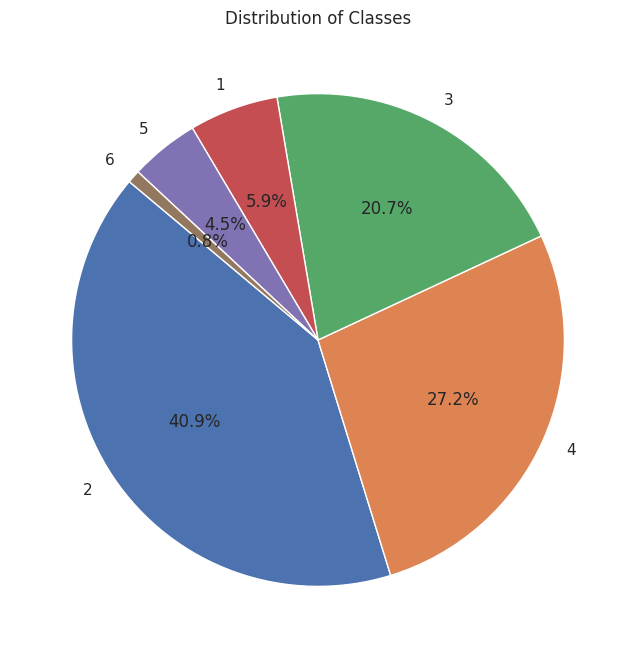

In [7]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_1D`: PM2.5 ritardato di 1 giorno
- `pm_lag_2D`: PM2.5 ritardato di 2 giorni
- `pm_lag_3D`: PM2.5 ritardato di 3 giorni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_1D`: CO ritardato di 1 giorno
- `co_lag_2D`: CO ritardato di 2 giorni
- `co_lag_3D`: CO ritardato di 1 anno
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_1D`: O3 ritardato di 1 giorno
- `o3_lag_2D`: O3 ritardato di 2 giorni
- `o3_lag_3D`: O3 ritardato di 3 giorni

La variabile target per il nostro modello di addestramento sarà una variabile **discreta**, composta da 6 valori distinti. Questi valori rappresentano i diversi livelli di qualità dell'aria, come definiti dalla scala dell'**Environmental Protection Agency (EPA)** degli Stati Uniti per la concentrazione di PM2.5.

Possiamo mappare numericamente questi livelli alle seguenti classi, mantenendo l'ordine implicito di gravità:

* **1: "Good"** (Concentrazione di PM2.5: $0 - 9.0 \mu g/m^3$)
* **2: "Moderate"** (Concentrazione di PM2.5: $9.1 - 35.4 \mu g/m^3$)
* **3: "Unhealthy for Sensitive Groups"** (Concentrazione di PM2.5: $35.5 - 55.4 \mu g/m^3$)
* **4: "Unhealthy"** (Concentrazione di PM2.5: $55.5 - 125.4 \mu g/m^3$)
* **5: "Very Unhealthy"** (Concentrazione di PM2.5: $125.5 - 225.4 \mu g/m^3$)
* **6: "Hazardous"** (Concentrazione di PM2.5: $> 225.5 \mu g/m^3$)

Adottando questo schema, il problema si configura come un task di **classificazione multi-classe**. L'obiettivo del modello sarà prevedere a quale di questi 6 livelli di qualità dell'aria (o "categorie di rischio") appartiene una data osservazione, basandosi sulle caratteristiche di input fornite.

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [8]:
target = 'Class'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W','pm_lag_1D','co_lag_1D','o3_lag_1D','pm_lag_2D','co_lag_2D','o3_lag_2D','pm_lag_3D','co_lag_3D','o3_lag_3D']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [9]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [10]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati eliminando l’indice precedente,
# in modo da partire da zero ed avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

/scratch.hpc/martin.tomassi/venv_pm/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26319 entries, 0 to 26318
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  26319 non-null  int64   
 1   dayofweek   26319 non-null  int64   
 2   dayofyear   26319 non-null  int64   
 3   weekofyear  26319 non-null  int64   
 4   month       26319 non-null  int64   
 5   quarter     26319 non-null  int64   
 6   year        26319 non-null  int64   
 7   state       26319 non-null  category
 8   pm_lag_1Y   26319 non-null  float64 
 9   pm_lag_2Y   26319 non-null  float64 
 10  pm_lag_1M   26319 non-null  float64 
 11  pm_lag_1W   26319 non-null  float64 
 12  co_lag_1Y   26319 non-null  float64 
 13  co_lag_2Y   26319 non-null  float64 
 14  co_lag_1M   26319 non-null  float64 
 15  co_lag_1W   26319 non-null  float64 
 16  o3_lag_1Y   26319 non-null  float64 
 17  o3_lag_2Y   26319 non-null  float64 
 18  o3_lag_1M   26319 non-null  float64 
 19  o3_l

In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6580 entries, 0 to 6579
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  6580 non-null   int64   
 1   dayofweek   6580 non-null   int64   
 2   dayofyear   6580 non-null   int64   
 3   weekofyear  6580 non-null   int64   
 4   month       6580 non-null   int64   
 5   quarter     6580 non-null   int64   
 6   year        6580 non-null   int64   
 7   state       6580 non-null   category
 8   pm_lag_1Y   6580 non-null   float64 
 9   pm_lag_2Y   6580 non-null   float64 
 10  pm_lag_1M   6580 non-null   float64 
 11  pm_lag_1W   6580 non-null   float64 
 12  co_lag_1Y   6580 non-null   float64 
 13  co_lag_2Y   6580 non-null   float64 
 14  co_lag_1M   6580 non-null   float64 
 15  co_lag_1W   6580 non-null   float64 
 16  o3_lag_1Y   6580 non-null   float64 
 17  o3_lag_2Y   6580 non-null   float64 
 18  o3_lag_1M   6580 non-null   float64 
 19  o3_lag

In [13]:
print(y_train.value_counts())

Class
2    10177
4     8159
3     5925
5     1436
6      323
1      299
Name: count, dtype: int64


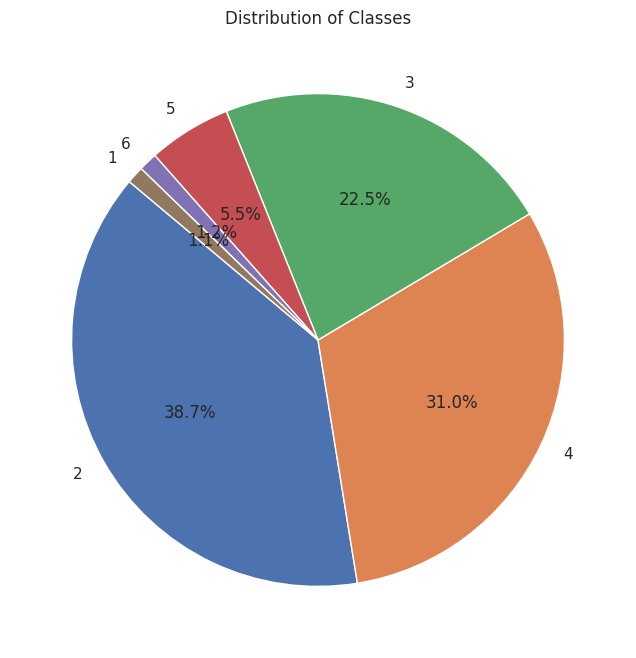

In [14]:
plt.figure(figsize=(8, 8))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

In [15]:
print(y_test.value_counts())

Class
2    2727
4    1831
3    1364
1     321
5     307
6      30
Name: count, dtype: int64


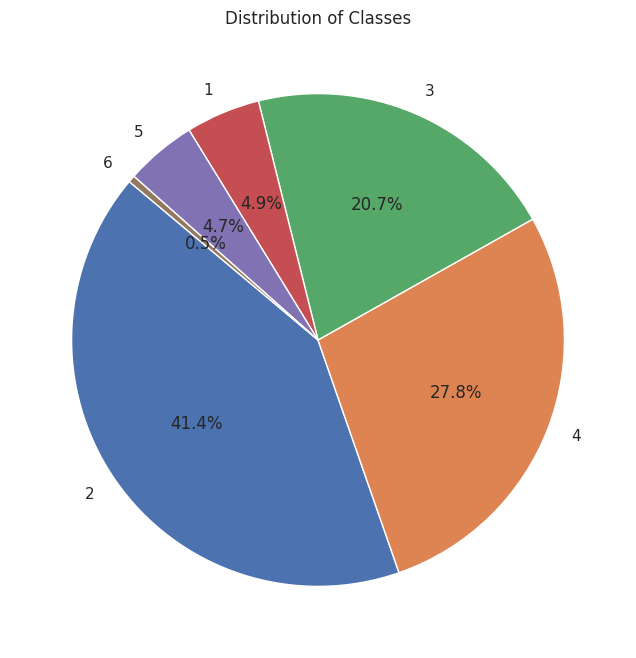

In [16]:
plt.figure(figsize=(8, 8))
plt.pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [17]:
categorical_features = X_train.select_dtypes(include=["category"]).columns.tolist()
numerical_features   = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [18]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli

Dopo l’allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo le funzioni `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Queste metriche sono state scelte specificamente per valutare l'efficacia dei modelli in problemi di **classificazione multi-classe, con particolare attenzione alle classi sbilanciate**.

Le metriche calcolate sono:

1.  **Accuracy Score**
    Misura la percentuale di istanze classificate correttamente dal modello. Sebbene sia una metrica intuitiva, può essere fuorviante in presenza di classi sbilanciate, poiché un modello che classifica correttamente solo la classe maggioritaria può comunque mostrare un'alta accuratezza.
    *(Più alto è, meglio è.)*

2.  **F1-Score (Weighted)**
    L'F1-Score è la media armonica della Precisione e del Recall. La versione "weighted" calcola la media di F1-Score per ciascuna classe, pesandola in base al numero di istanze di quella classe nel dataset. Questa metrica è particolarmente utile per dataset con classi sbilanciate, in quanto fornisce una visione più bilanciata delle prestazioni del modello su tutte le classi, evitando di essere dominata dalla classe maggioritaria.
    *(Più alto è, meglio è.)*

3.  **F1-Score (Macro)**
    La versione "macro" dell'F1-Score calcola la media non pesata di F1-Score per ciascuna classe. Questo significa che ogni classe contribuisce in modo uguale alla metrica finale, indipendentemente dal suo numero di campioni. È utile quando tutte le classi, comprese quelle minoritarie, hanno la stessa importanza.
    *(Più alto è, meglio è.)*

4.  **Matrice di Confusione**
    Una tabella che riassume le prestazioni di un algoritmo di classificazione. Mostra il numero di previsioni corrette e sbagliate per ciascuna classe, indicando dove il modello sta confondendo le diverse categorie. È fondamentale per comprendere gli errori specifici del modello.

5.  **Classification Report**
    Fornisce un riepilogo dettagliato delle metriche di Precisione, Recall e F1-Score per ciascuna classe, oltre a metriche aggregate (macro avg, weighted avg). È uno strumento essenziale per una valutazione approfondita delle prestazioni per classe.

6.  **AUC-ROC (Area Under the Receiver Operating Characteristic Curve) - One-vs-Rest Weighted**
    L'AUC-ROC misura la capacità del modello di distinguere tra le classi. Per problemi multi-classe, si calcola spesso in modalità "one-vs-rest", trattando ogni classe come "positiva" e tutte le altre come "negative". La versione "weighted" ne calcola la media pesata per la frequenza delle classi, rendendola più robusta per dataset sbilanciati. Un valore più vicino a 1 indica una maggiore capacità discriminatoria.
    *(Più alto è, meglio è.)*

7.  **AUC-PR (Area Under the Precision-Recall Curve) - One-vs-Rest Weighted**
    L'AUC-PR è particolarmente utile per dataset con classi sbilanciate e quando la classe positiva (minoritaria) è di maggiore interesse. Misura l'area sotto la curva Precision-Recall, offrendo una valutazione più accurata della capacità del modello di identificare correttamente le istanze positive rispetto all'AUC-ROC, che può essere ottimistica in presenza di un grande numero di veri negativi. Per multi-classe, viene calcolata in modalità "one-vs-rest" e mediata pesando per la frequenza delle classi.
    *(Più alto è, meglio è.)*

In [19]:
def count_params(model):
    if isinstance(model, ImbPipeline):
        model = model.steps[-1][1]

    if hasattr(model, 'parameters') and inspect.ismethod(model.parameters) and not isinstance(model, KAN):
        try:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        except Exception:
            return 0

    elif isinstance(model, KAN):
        try:
            if not model.width or len(model.width) < 2:
                return 0
            else:
                sum_edge_terms = 0
                for i in range(len(model.width) - 1):
                    Nl = model.width[i]
                    Nl_plus_1 = model.width[i+1]
                    if isinstance(Nl, list): Nl = Nl[0]
                    if isinstance(Nl_plus_1, list): Nl_plus_1 = Nl_plus_1[0]
                    G = model.grid
                    k = model.k
                    sum_edge_terms += Nl * Nl_plus_1 * (G + k - 1)
                return sum_edge_terms
        except Exception as e:
            print(f"Error calculating KAN parameters: {e}")
            return 0

    elif isinstance(model, RandomForestClassifier):
        total_nodes = 0
        if hasattr(model, 'estimators_'):
            for tree in model.estimators_:
                if hasattr(tree, 'tree_'):
                    total_nodes += tree.tree_.node_count
            return total_nodes
        else:
            return 0

    elif isinstance(model, xgb.XGBClassifier):
        total_nodes = 0

        try:
            booster = model.get_booster()
            tree_dumps = booster.get_dump(dump_format='json')

            def count_nodes_in_json_tree(node):
                count = 1
                if 'children' in node:
                    for child in node['children']:
                        count += count_nodes_in_json_tree(child)
                return count

            for tree_dump_str in tree_dumps:
                tree_json = json.loads(tree_dump_str)
                total_nodes += count_nodes_in_json_tree(tree_json)

            return total_nodes
        except Exception as e:
            print(f"Error calculating exact XGBoost complexity: {e}")
            return 0
    else:
        return 0

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05, **metric_kwargs):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        idx = np.random.randint(0, n_samples, n_samples)
        vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx], **metric_kwargs))

    low = np.percentile(vals, 100 * (alpha / 2))
    high = np.percentile(vals, 100 * (1 - alpha / 2))
    return low, high

def get_estimator_scores(model_name, model, X_test, y_test, X_train, y_train, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} ---")

    # Calcola la Complessitá dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters/Nodes: {param_count}")

    # Previsioni (etichette hard) per test e train
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Se il modello supporta predict_proba (per AUC)
    y_proba_test = None
    if hasattr(model, 'predict_proba'):
        y_proba_test = model.predict_proba(X_test) # Probabilità per ogni classe

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train, y_pred_train)
    f1_weighted_tr = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test, y_pred_test)
    f1_weighted_te = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

    # Bootstrap CI per F1-weighted
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='macro', zero_division=0
    )

    # Matrice di Confusione e Classification Report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_pred_test))

    # Raccolta dei punteggi
    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC se possibile (necessita probabilità)
    if y_proba_test is not None:
        try:
            num_classes = len(np.unique(y_test))
            auc_roc_ovr = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr_ovr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')

            # Bootstrap per AUC-ROC e AUC-PR
            auc_roc_low, auc_roc_high = bootstrap_ci(
                lambda yt, yp: roc_auc_score(yt, yp, multi_class='ovr', average='weighted'),
                y_test, y_proba_test
            )
            auc_pr_low, auc_pr_high = bootstrap_ci(
                lambda yt, yp: average_precision_score(pd.get_dummies(yt), yp, average='weighted'),
                y_test, y_proba_test
            )

            scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
            print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
            print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

        except ValueError as e:
            print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
            scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    else:
        print("Modello non supporta predict_proba. AUC/PR non calcolabili.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC

    all_scores_list.append(scores_row)


def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    return out # Restituisce logit/probabilità, non etichette hard qui


def get_torch_estimator_scores(model_name, model,
                               X_train_tensor, y_train_tensor,
                               X_test_tensor, y_test_tensor,
                               device, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} (PyTorch) ---")

    # Calcola il numero di Parametri dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters: {param_count}")

    # Ottieni output (logits/probabilità) dal modello
    y_pred_proba_train = predict_torch(model, X_train_tensor, device)
    y_pred_proba_test = predict_torch(model, X_test_tensor, device)

    # Converti le etichette vere (tensori) in numpy array per Scikit-learn
    y_train_np = y_train_tensor.detach().cpu().numpy()
    y_test_np = y_test_tensor.detach().cpu().numpy()

    # Se il modello emette logit, converti in probabilità e poi in etichette
    y_pred_labels_train = torch.argmax(softmax(y_pred_proba_train, dim=1), dim=1).detach().cpu().numpy()
    y_pred_labels_test = torch.argmax(softmax(y_pred_proba_test, dim=1), dim=1).detach().cpu().numpy()

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train_np, y_pred_labels_train)
    f1_weighted_tr = f1_score(y_train_np, y_pred_labels_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train_np, y_pred_labels_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test_np, y_pred_labels_test)
    f1_weighted_te = f1_score(y_test_np, y_pred_labels_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test_np, y_pred_labels_test, average='macro', zero_division=0)

    # Bootstrap CI
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='macro', zero_division=0
    )

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_np, y_pred_labels_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test_np, y_pred_labels_test))

    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC (necessita probabilità)
    try:
        auc_roc_ovr = roc_auc_score(y_test_np, softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                    multi_class='ovr', average='weighted')
        auc_pr_ovr = average_precision_score(pd.get_dummies(y_test_np), softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                            average='weighted')

        # Bootstrap per AUC-ROC e AUC-PR
        auc_roc_low, auc_roc_high = bootstrap_ci(
            lambda yt, yp: roc_auc_score(yt, softmax(torch.tensor(yp), dim=1).numpy(), multi_class='ovr', average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )
        auc_pr_low, auc_pr_high = bootstrap_ci(
            lambda yt, yp: average_precision_score(pd.get_dummies(yt), softmax(torch.tensor(yp), dim=1).numpy(), average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )

        scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
        print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
        print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

    except ValueError as e:
        print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    except Exception as e:
        print(f"Errore generico nel calcolo di AUC/PR per PyTorch: {e}")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN

    all_scores_list.append(scores_row)

## Cross Validation TimeSeriesSplit
La validazione viene eseguita con `TimeSeriesSplit`, una tecnica di cross-validation adatta alle Serie Temporali, che preserva l’ordine cronologico dividendo il dataset in fold sequenziali.

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

Nel blocco seguente viene visualizzata la suddivisione del dataset nei 5 fold della Time Series Cross-Validation.  
Questa rappresentazione è utile per verificare che la sequenza temporale sia rispettata nella divisione dei dati tra training e validation set.


Fold 1:
-- Training set class distribution: --
Class
1       2
2    1016
3    1000
4    1740
5     492
6     139
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      45
2    1786
3    1288
4    1139
5     114
6      14
Name: count, dtype: int64
--------------------
Fold 2:
-- Training set class distribution: --
Class
1      47
2    2802
3    2288
4    2879
5     606
6     153
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      23
2    1692
3     980
4    1375
5     252
6      64
Name: count, dtype: int64
--------------------


Fold 3:
-- Training set class distribution: --
Class
1      70
2    4494
3    3268
4    4254
5     858
6     217
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      31
2    1697
3     812
4    1467
5     313
6      66
Name: count, dtype: int64
--------------------
Fold 4:
-- Training set class distribution: --
Class
1     101
2    6191
3    4080
4    5721
5    1171
6     283
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1     133
2    2651
3     888
4     654
5      44
6      16
Name: count, dtype: int64
--------------------


Fold 5:
-- Training set class distribution: --
Class
1     234
2    8842
3    4968
4    6375
5    1215
6     299
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      65
2    1335
3     957
4    1784
5     221
6      24
Name: count, dtype: int64
--------------------


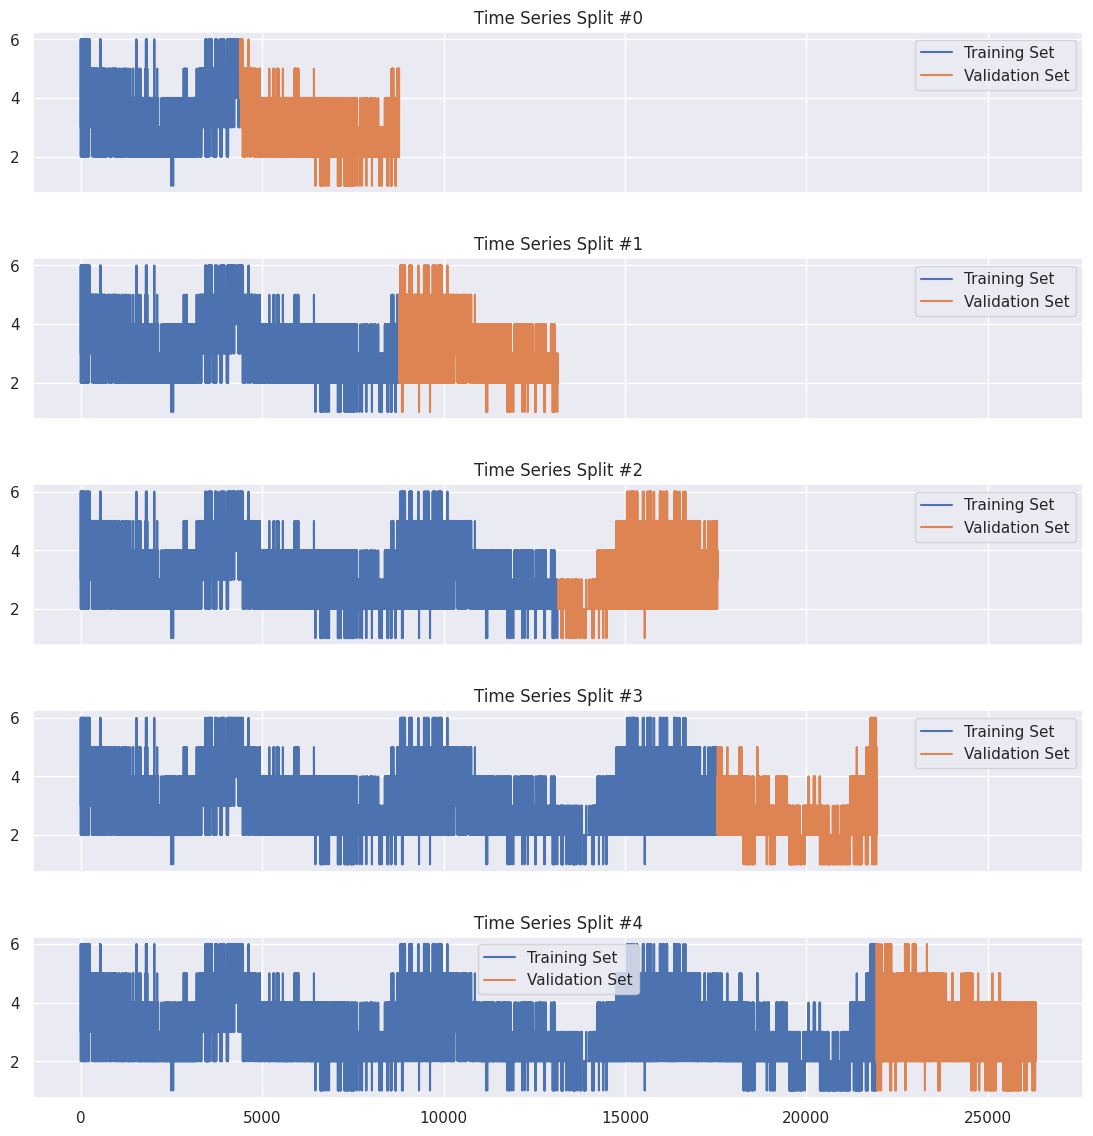

In [21]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

    print(f"Fold {index+1}:")
    print("-- Training set class distribution: --")
    print(y_train.iloc[train_fold].value_counts().sort_index())
    print("-- Validation set class distribution: --")
    print(y_train.iloc[validation_fold].value_counts().sort_index())
    print("-" * 20)

plt.show()

## Custom SMOTE for Random Forest and XGBoost

In [22]:
class SmoteKNeighbors(SMOTE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _fit_resample(self, X, y):
        counts = np.bincount(y)
        minority_class = np.argmin(counts)
        n_samples_minority = counts[minority_class]
        
        if self.k_neighbors >= n_samples_minority:
            new_k_neighbors = max(1, n_samples_minority - 1)
            
            original_k_neighbors = self.k_neighbors
            self.k_neighbors = new_k_neighbors
            
            print(f"Warning: k_neighbors too high. Adjusting from {original_k_neighbors} to {self.k_neighbors} for this fold.")
            
            X_res, y_res = super()._fit_resample(X, y)
            
            self.k_neighbors = original_k_neighbors
            
            return X_res, y_res
        else:
            return super()._fit_resample(X, y)

## Random forest
Il modello Random Forest è un ensemble di alberi decisionali che migliora la stabilità e la capacità predittiva rispetto a un singolo albero. Ogni albero viene addestrato su un sottoinsieme casuale del dataset (bagging) e valuta solo una parte delle feature, rendendo l’insieme più robusto a overfitting e variazioni nei dati.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `max_samples=0.2`: ogni albero è addestrato su un campione casuale del 20% dei dati originali (con ripetizione);
- `max_features='sqrt'`: ogni nodo dell’albero valuta solo un sottoinsieme di feature pari alla radice quadrata del numero totale di feature disponibili;
- `n_estimators=200`: il modello è composto da 200 alberi decisionali;
- `max_depth=None`: gli alberi possono crescere fino a foglie pure, senza una profondità massima prefissata;
- `n_jobs=-1`: sfrutta tutti i core CPU disponibili per il training parallelo;
- `random_state=RANDOM_STATE`: Per la riproducibilità.
- `class_weight='balanced'`: attribuisce un peso inversamente proporzionale alla frequenza delle classi per gestire eventuali sbilanciamenti nel dataset.

In [23]:
model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(max_samples=0.2, max_features="sqrt",
                                    n_estimators=200, max_depth=None,
                                    n_jobs=N_JOBS, random_state=RANDOM_STATE,
                                    class_weight='balanced'))
])

In [24]:
%time model.fit(X_train, y_train)
print()

CPU times: user 24.9 s, sys: 299 ms, total: 25.2 s
Wall time: 7.39 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [25]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D    0.223789
numeric__pm_lag_2D    0.109891
numeric__pm_lag_3D    0.092542
numeric__pm_lag_1W    0.060801
numeric__pm_lag_1Y    0.044712
numeric__co_lag_1D    0.042311
numeric__pm_lag_2Y    0.035234
numeric__pm_lag_1M    0.032467
numeric__co_lag_2D    0.028231
numeric__co_lag_3D    0.024183
dtype: float64

### Hyperparameter Tuning per Random Forest

Eseguiamo una ricerca randomizzata (`RandomizedSearchCV`) per ottimizzare un insieme ampio di iperparametri fondamentali del modello Random Forest:

- `n_estimators`: numero di alberi nella foresta;
- `max_samples`: frazione massima di campioni usata per addestrare ogni singolo albero;
- `max_depth`: profondità massima degli alberi;
- `min_samples_leaf`: numero minimo di campioni richiesti per una foglia;
- `max_features`: numero massimo di feature da considerare per ogni split.

In questa fase di tuning, la pipeline include anche la tecnica di oversampling **SMOTE**, applicata correttamente all'interno di ogni fold di **Time Series Cross-Validation** per evitare il data leakage.

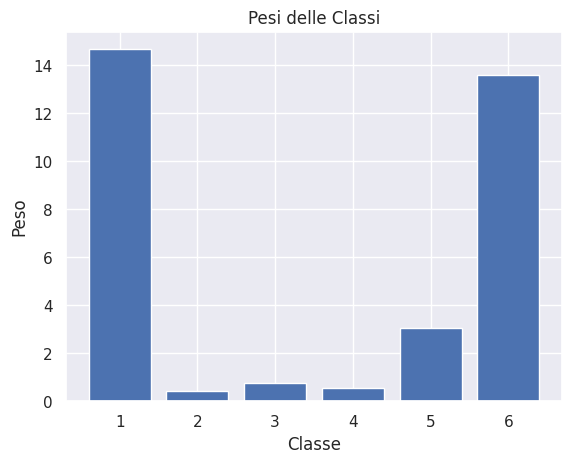

In [26]:
class_labels = np.unique(y_train)
initial_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
initial_class_weight_dict = dict(zip(class_labels, initial_weights))
plt.bar(class_labels, initial_weights)
plt.title('Pesi delle Classi')
plt.xlabel('Classe')
plt.ylabel('Peso')
plt.show()

In [27]:
grid_rf = {
    'tree__n_estimators': [100, 150, 200],
    'tree__max_samples': [0.5, 0.7, 0.9],
    'tree__max_depth': [5, 10, 15],
    'tree__min_samples_split': [2, 5],
    'tree__min_samples_leaf': [2, 5],
    'tree__max_features': ['sqrt', 'log2']
}

model_ht_rf = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SmoteKNeighbors(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

gs_rf = RandomizedSearchCV(model_ht_rf, grid_rf, n_iter=49, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 216
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 216.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{216}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{206}{216}\right)} = \frac{-2.3026}{\ln(206/216)} \approx \frac{2.3026}{0.0474} \approx 48.58
$$

Quindi, con **49 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 216 combinazioni.

---

**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [28]:
%time gs_rf.fit(X_train, y_train)
print()

CPU times: user 46.7 s, sys: 1.2 s, total: 47.9 s
Wall time: 13min 42s



In [29]:
get_estimator_scores("random_forest", gs_rf.best_estimator_, X_test, y_test, X_train, y_train, all_scores)


--- Valutazione Prestazioni per random_forest ---
Model Parameters/Nodes: 698164



Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.82      0.73      0.77       321
           2       0.89      0.87      0.88      2727
           3       0.65      0.69      0.67      1364
           4       0.84      0.80      0.82      1831
           5       0.63      0.82      0.71       307
           6       0.37      0.33      0.35        30

    accuracy                           0.80      6580
   macro avg       0.70      0.71      0.70      6580
weighted avg       0.81      0.80      0.80      6580


Confusion Matrix (Test Set):
[[ 234   87    0    0    0    0]
 [  52 2369  288   18    0    0]
 [   1  201  946  215    1    0]
 [   0   14  218 1472  126    1]
 [   0    1    0   39  251   16]
 [   0    0    0    0   20   10]]


AUC-ROC (OVR, Weighted): 0.953
AUC-PR (OVR, Weighted): 0.860


## XGBoost

XGBoost è un'implementazione ottimizzata di algoritmi di gradient boosting. A differenza del Random Forest che costruisce alberi indipendenti e poi ne aggrega i risultati, XGBoost costruisce alberi in sequenza, con ogni nuovo albero che corregge gli errori degli alberi precedenti.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `sampler`: **SMOTE (Synthetic Minority Over-sampling Technique)**, che genera nuovi campioni sintetici per le classi minoritarie, rendendo il dataset più bilanciato per l'addestramento. `random_state` garantisce la riproducibilità.
- `xgb`: il classificatore XGBoost con i seguenti iperparametri iniziali:
    - `objective='multi:softprob'`: Specifica la funzione obiettivo di classificazione multi-classe, dove l'output è un array di probabilità per ogni classe. Questo è necessario per le metriche AUC.
    - `num_class`: numero totale di classi.
    - `n_estimators=200`: numero di alberi di boosting da costruire.
    - `learning_rate=0.1`: La dimensione del passo di ridimensionamento del contributo di ogni albero.
    - `use_label_encoder=False`: parametro deprecato e quindi va disabilitato per evitare warning.
    - `eval_metric='mlogloss'`: metrica di valutazione da usare durante l'addestramento.
    - `n_jobs=N_JOBS`: Sfrutta tutti i core CPU disponibili per il training parallelo.
    - `random_state=RANDOM_STATE`: Per la riproducibilità.

**Nota Importante:** Per XGBoost con multi-classe, le etichette della classe devono essere convertite in indici che partono da 0.

In [30]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1
num_classes = len(np.unique(y_train_xgb))

model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              n_estimators=200,
                              learning_rate=0.1,
                              use_label_encoder=False, # Deprecato, imposto a False
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

In [31]:
%time model.fit(X_train, y_train_xgb)
print()

CPU times: user 55.5 s, sys: 540 ms, total: 56 s
Wall time: 16 s



Possiamo ricavare le 10 feature più importanti per l'XGBoost Classifier, ovvero le variabili che sono state più utilizzate nella creazione degli alberi di boosting.

In [32]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D                  0.373324
categorical__state_Mizoram          0.032396
categorical__state_Jharkhand        0.032081
categorical__state_Delhi            0.031139
categorical__state_Gujarat          0.025636
categorical__state_Bihar            0.024329
categorical__state_Uttar Pradesh    0.023500
categorical__state_Telangana        0.021301
categorical__state_Karnataka        0.017804
categorical__state_Assam            0.017711
dtype: float32

### Hyperparameter Tuning per XGBoost
Eseguiamo una ricerca esaustiva (GridSearchCV) per ottimizzare iperparametri fondamentali del modello XGBoost, combinandoli con la tecnica di resampling SMOTE. Ottimizzeremo:
- `n_estimators`: Numero di alberi di boosting.
- `learning_rate`: La dimensione del passo che riduce il contributo di ogni nuovo albero.
- `max_depth`: La profondità massima di un albero.

In questa fase di tuning, la pipeline includerà anche la tecnica di oversampling SMOTE, che verrà applicata in modo appropriato a ogni fold di cross-validation per garantire che il modello sia addestrato su un dataset bilanciato senza data leakage.


---

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 432
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 432.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{432}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{422}{432}\right)} = \frac{-2.3026}{\ln(\frac{422}{432})} \approx \frac{2.3026}{0.0234} \approx 98.40
$$

Quindi, con **98** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 432 combinazioni.

---

In [33]:
grid_xgb = {
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__subsample": [0.7, 0.9],
    "xgb__colsample_bytree": [0.7, 0.9],
    "xgb__gamma": [0, 0.2, 0.4],
    "xgb__min_child_weight": [1, 5]
}

model_ht_xgb = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SmoteKNeighbors(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              use_label_encoder=False,
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

gs_xgb = RandomizedSearchCV(model_ht_xgb, grid_xgb, n_iter=98, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

In [34]:
%time gs_xgb.fit(X_train, y_train_xgb)
print()

CPU times: user 1min 11s, sys: 4.07 s, total: 1min 15s
Wall time: 24min 6s



In [35]:
get_estimator_scores("xgboost", gs_xgb.best_estimator_, X_test, y_test_xgb, X_train, y_train_xgb, all_scores)


--- Valutazione Prestazioni per xgboost ---


Model Parameters/Nodes: 90656



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       321
           1       0.90      0.87      0.88      2727
           2       0.66      0.68      0.67      1364
           3       0.83      0.83      0.83      1831
           4       0.65      0.71      0.68       307
           5       0.34      0.40      0.37        30

    accuracy                           0.81      6580
   macro avg       0.69      0.71      0.70      6580
weighted avg       0.81      0.81      0.81      6580


Confusion Matrix (Test Set):
[[ 249   72    0    0    0    0]
 [  73 2364  266   24    0    0]
 [   2  198  931  232    1    0]
 [   1    4  205 1523   97    1]
 [   0    1    0   65  219   22]
 [   0    0    0    0   18   12]]


AUC-ROC (OVR, Weighted): 0.957
AUC-PR (OVR, Weighted): 0.876


## MLP and KAN


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout, num_classes):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def build_kan(input_dim, width, grid, k, num_classes, seed=0):
    model = KAN(
        width=[input_dim] + list(width) + [num_classes],
        grid=grid,
        k=k,
        seed=seed,
        device=device
    )
    model.speed()  # enable efficient mode: disable symbolic branch
    return model

Device utilizzato: cuda


### Implementazione dell’Early Stopping

La classe `EarlyStopper` implementa una logica di early stopping che interrompe anticipatamente l’addestramento se la performance sul validation set non migliora oltre una soglia (min_delta) per un numero consecutivo di epoche (patience).
Questo approccio aiuta a evitare l’overfitting e riduce i tempi di addestramento, salvando il modello con la miglior loss di validazione osservata.

In [37]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Funzioni per il training e la valutazione

- `train_epoch`: esegue una singola epoca di training. Calcola le previsioni, applica la loss function, esegue il backpropagation e aggiorna i pesi del modello. La loss viene aggregata e normalizzata sulla dimensione del dataset.

- `eval_loss`: calcola la loss media del modello sul validation set in modalità eval, disabilitando l’aggiornamento dei pesi. Questo è fondamentale per valutare le prestazioni in modo affidabile durante il training.

In [38]:
def train_epoch(model, loader, optimizer, criterion, l2_lambda=0.0):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)

        if l2_lambda > 0:
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb.long()).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

### Random Search con Cross-Validation temporale e Early Stopping

La funzione `random_search` implementa una strategia di ottimizzazione degli iperparametri che:

- Estrae in modo casuale combinazioni di iperparametri dallo spazio definito (param_dist);
- Valuta ogni configurazione tramite Cross Validation TimeSeriesSplit per rispettare l’ordine temporale dei dati;
- Addestra un modello MLP per ciascun fold monitorando la loss di validazione;
- Applica early stopping durante l’allenamento per evitare overfitting;
- Calcola la media delle validation loss su tutti i fold per ogni configurazione.

La combinazione con la miglior media viene salvata come modello ottimale, insieme agli iperparametri migliori.

In [39]:
def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4,
                  class_weights=None,
                  smote_k_neighbors=6):
    train_keys = ['lr', 'l2_lambda']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Randomized Search")

    smote = SMOTE(
        k_neighbors=smote_k_neighbors,
        random_state=RANDOM_STATE
    )

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            # Estrai i dati del fold di training
            train_features = dataset.tensors[0][train_idx].cpu().numpy()
            train_labels = dataset.tensors[1][train_idx].cpu().numpy()

            # Estrai i dati di validazione
            val_features = dataset.tensors[0][val_idx]
            val_labels = dataset.tensors[1][val_idx]

            # Applica SMOTE al training set
            try:
                # Verifica che ci siano almeno 2 classi nel training set
                unique_classes = np.unique(train_labels)
                if len(unique_classes) < 2:
                    print(f"    Warning: Solo {len(unique_classes)} classe/i nel fold {fold_idx+1}. Skip SMOTE.")
                    train_features_resampled = train_features
                    train_labels_resampled = train_labels
                else:
                    # Verifica che ogni classe abbia almeno k_neighbors+1 campioni
                    min_samples = min([np.sum(train_labels == cls) for cls in unique_classes])
                    if min_samples <= smote_k_neighbors:
                        print(f"    Warning: Alcune classi hanno meno di {smote_k_neighbors+1} campioni. Riduco k_neighbors.")
                        smote_fold = SMOTE(
                            k_neighbors=min(min_samples-1, 1),
                            random_state=RANDOM_STATE
                        )
                    else:
                        smote_fold = smote

                    train_features_resampled, train_labels_resampled = smote_fold.fit_resample(
                        train_features, train_labels
                    )

                    print(f"    SMOTE applicato: {len(train_features)} -> {len(train_features_resampled)} campioni")

                    # Mostra la distribuzione delle classi dopo SMOTE
                    unique, counts = np.unique(train_labels_resampled, return_counts=True)
                    print(f"    Distribuzione post-SMOTE: {{{', '.join(f'{u}: {c}' for u, c in zip(unique, counts))}}}")

            except Exception as e:
                print(f"    Warning: SMOTE fallito ({str(e)}). Uso dataset originale.")
                train_features_resampled = train_features
                train_labels_resampled = train_labels

            # Converti back a tensori PyTorch
            train_features_tensor = torch.FloatTensor(train_features_resampled)
            train_labels_tensor = torch.LongTensor(train_labels_resampled)

            # Crea i dataset bilanciati
            balanced_train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
            val_dataset = TensorDataset(val_features, val_labels)

            # Crea i DataLoader
            train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

            # Inizializza e addestra il modello
            model = model_builder(**model_params)
            if hasattr(model, 'speed'):
                model.speed()
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            criterion = nn.CrossEntropyLoss()
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(1000):
                train_loss = train_epoch(model, train_loader, optimizer, criterion, l2_lambda=train_params.get('l2_lambda', 0.0))
                val_loss = eval_loss(model, val_loader, criterion)

                if epoch % 10 == 0:
                    print(f"    Epoch {epoch}: train_loss = {train_loss:.6f}, val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}, best_val_loss: {stopper.best_loss:.6f}")
                    break

            final_val_loss = eval_loss(model, val_loader, criterion)
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model_builder(**best_model_params).to(device)
            best_model.load_state_dict(model.state_dict())
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Preparazione dati e spazio di ricerca iperparametri

In questa sezione:

- Applichiamo la trasformazione dei dati tramite il preprocessor già definito in precedenza;

- Convertiamo le etichette y_train e y_test in formato 0-indexed, come richiesto dalla CrossEntropyLoss di PyTorch;

- Creiamo un dataset PyTorch (TensorDataset) con input e target;

- Definiamo lo spazio di ricerca per gli iperparametri, tra cui:

 Architettura della rete (hidden_sizes);

 Dropout;

 Tasso di apprendimento (lr);

 Numero di classi.

Calcoliamo infine i pesi delle classi per bilanciare la loss in presenza di squilibri nella distribuzione delle etichette.

In [40]:
X_train_processed = preprocessor.fit_transform(X_train) # Fit and transform on training data
X_test_processed = preprocessor.transform(X_test) # Only transform on test data

y_train_0_indexed = y_train.values - 1
y_test_0_indexed = y_test.values - 1

X_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_train_0_indexed, dtype=torch.long)

full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
num_classes = len(np.unique(y_train_0_indexed))

mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(64,64), (128,), (128, 64), (256, 128), (512, 256)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}
kan_param_dist = {
    'input_dim': [input_dim],
    'width': [(8,4), (16, 8), (32, 16), (64, 32)],
    'grid': [5, 10, 20],
    'k': [2, 4],
    'seed': [0],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}

class_labels_0_indexed = np.unique(y_train_0_indexed)
class_weights_balanced = compute_class_weight(class_weight='balanced', classes=class_labels_0_indexed, y=y_train_0_indexed)
class_weights_dict = dict(zip(class_labels_0_indexed, class_weights_balanced))

### Avvio della ricerca e valutazione

- Eseguiamo la funzione random_search, fornendo:

 Il costruttore della rete MLP;

 Lo spazio degli iperparametri;

 Il dataset PyTorch e i pesi delle classi calcolati in precedenza;

- Al termine, il modello con la miglior media di validation loss viene selezionato e restituito;

In [41]:
%%time
print("MLP Results:")
best_model_mlp, model_params_mlp, train_params_mlp = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=26
)

MLP Results:
Avvio Randomized Search
Testing parameter set 1/26
  Fold 1/5


    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.919532, val_loss = 0.844039


    Early stopping at epoch 8, best_val_loss: 0.734814


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.847608, val_loss = 1.023991


    Epoch 10: train_loss = 0.435240, val_loss = 0.781998


    Early stopping at epoch 12, best_val_loss: 0.732692
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.796455, val_loss = 0.833798


    Epoch 10: train_loss = 0.428346, val_loss = 0.553319
    Early stopping at epoch 10, best_val_loss: 0.524013
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.740874, val_loss = 0.824793


    Early stopping at epoch 8, best_val_loss: 0.527835
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.681666, val_loss = 0.748787


    Early stopping at epoch 6, best_val_loss: 0.682837
  Mean validation loss: 0.674223
  New best validation loss: 0.674223
Testing parameter set 2/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.544197, val_loss = 1.625542


    Epoch 10: train_loss = 0.660868, val_loss = 0.857036


    Epoch 20: train_loss = 0.575587, val_loss = 0.783164


    Epoch 30: train_loss = 0.532136, val_loss = 0.765314


    Epoch 40: train_loss = 0.506604, val_loss = 0.740754


    Epoch 50: train_loss = 0.486661, val_loss = 0.734833
    Early stopping at epoch 50, best_val_loss: 0.733107


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.471554, val_loss = 1.477230


    Epoch 10: train_loss = 0.636360, val_loss = 0.873438


    Epoch 20: train_loss = 0.574333, val_loss = 0.822141


    Epoch 30: train_loss = 0.541679, val_loss = 0.808095


    Epoch 40: train_loss = 0.509593, val_loss = 0.782136


    Early stopping at epoch 44, best_val_loss: 0.777884
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.359897, val_loss = 1.392028


    Epoch 10: train_loss = 0.623621, val_loss = 0.845328


    Epoch 20: train_loss = 0.553993, val_loss = 0.707296


    Epoch 30: train_loss = 0.512038, val_loss = 0.645591


    Epoch 40: train_loss = 0.484193, val_loss = 0.578521


    Early stopping at epoch 45, best_val_loss: 0.578521


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.249814, val_loss = 1.240408


    Epoch 10: train_loss = 0.589382, val_loss = 0.718533


    Epoch 20: train_loss = 0.523650, val_loss = 0.577261


    Epoch 30: train_loss = 0.488164, val_loss = 0.544841


    Early stopping at epoch 35, best_val_loss: 0.544841
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.146613, val_loss = 1.048811


    Epoch 10: train_loss = 0.544485, val_loss = 0.662542


    Early stopping at epoch 17, best_val_loss: 0.648612
  Mean validation loss: 0.662625
  New best validation loss: 0.662625
Testing parameter set 3/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.840449, val_loss = 0.824690


    Early stopping at epoch 9, best_val_loss: 0.759209
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.788174, val_loss = 0.876270


    Epoch 10: train_loss = 0.352806, val_loss = 0.764345


    Early stopping at epoch 11, best_val_loss: 0.716639
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.716345, val_loss = 0.801909


    Early stopping at epoch 9, best_val_loss: 0.541847
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.654690, val_loss = 0.718219


    Early stopping at epoch 6, best_val_loss: 0.564590
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.602983, val_loss = 0.646036


    Early stopping at epoch 6, best_val_loss: 0.619539
  Mean validation loss: 0.720606
Testing parameter set 4/26
  Fold 1/5


    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.429778, val_loss = 1.518605


    Epoch 10: train_loss = 0.631883, val_loss = 0.881973


    Epoch 20: train_loss = 0.544696, val_loss = 0.799671


    Epoch 30: train_loss = 0.498039, val_loss = 0.763222


    Epoch 40: train_loss = 0.463698, val_loss = 0.749055


    Epoch 50: train_loss = 0.444017, val_loss = 0.736858


    Epoch 60: train_loss = 0.426319, val_loss = 0.730365


    Early stopping at epoch 63, best_val_loss: 0.729070
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.364327, val_loss = 1.514479


    Epoch 10: train_loss = 0.622760, val_loss = 0.976047


    Epoch 20: train_loss = 0.548673, val_loss = 0.850891


    Epoch 30: train_loss = 0.508246, val_loss = 0.787646


    Epoch 40: train_loss = 0.485433, val_loss = 0.756184


    Epoch 50: train_loss = 0.462757, val_loss = 0.725787


    Epoch 60: train_loss = 0.448177, val_loss = 0.713236


    Epoch 70: train_loss = 0.432149, val_loss = 0.704065


    Early stopping at epoch 78, best_val_loss: 0.694903
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.260966, val_loss = 1.400396


    Epoch 10: train_loss = 0.594436, val_loss = 0.821904


    Epoch 20: train_loss = 0.525264, val_loss = 0.713556


    Epoch 30: train_loss = 0.487830, val_loss = 0.660084


    Epoch 40: train_loss = 0.463173, val_loss = 0.614264


    Epoch 50: train_loss = 0.444724, val_loss = 0.573869


    Epoch 60: train_loss = 0.428926, val_loss = 0.559758


    Epoch 70: train_loss = 0.417462, val_loss = 0.544182


    Epoch 80: train_loss = 0.408791, val_loss = 0.531678


    Early stopping at epoch 85, best_val_loss: 0.531678
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.210207, val_loss = 1.260627


    Epoch 10: train_loss = 0.565823, val_loss = 0.767843


    Epoch 20: train_loss = 0.497901, val_loss = 0.642635


    Epoch 30: train_loss = 0.467556, val_loss = 0.591834


    Epoch 40: train_loss = 0.445976, val_loss = 0.569812


    Epoch 50: train_loss = 0.430004, val_loss = 0.564124


    Early stopping at epoch 51, best_val_loss: 0.563521
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.102498, val_loss = 1.204002


    Epoch 10: train_loss = 0.526895, val_loss = 0.656145


    Epoch 20: train_loss = 0.471750, val_loss = 0.622245


    Early stopping at epoch 27, best_val_loss: 0.610052


  Mean validation loss: 0.631265
  New best validation loss: 0.631265
Testing parameter set 5/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.684816, val_loss = 0.799429


    Early stopping at epoch 6, best_val_loss: 0.779475
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.658063, val_loss = 0.838588


    Early stopping at epoch 6, best_val_loss: 0.708148
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.610378, val_loss = 0.662052


    Early stopping at epoch 7, best_val_loss: 0.525069
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.581756, val_loss = 0.592725


    Early stopping at epoch 5, best_val_loss: 0.592725


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.542822, val_loss = 0.645508


    Early stopping at epoch 5, best_val_loss: 0.645508
  Mean validation loss: 0.815262
Testing parameter set 6/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.740934, val_loss = 0.796049


    Early stopping at epoch 7, best_val_loss: 0.750673
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.708205, val_loss = 0.792703


    Epoch 10: train_loss = 0.338141, val_loss = 0.750211


    Early stopping at epoch 11, best_val_loss: 0.725663
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.672153, val_loss = 0.655628


    Early stopping at epoch 8, best_val_loss: 0.515630
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.627455, val_loss = 0.575561


    Early stopping at epoch 5, best_val_loss: 0.575561
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.589769, val_loss = 0.641627


    Early stopping at epoch 5, best_val_loss: 0.641627
  Mean validation loss: 0.744466
Testing parameter set 7/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.061981, val_loss = 0.984898


    Epoch 10: train_loss = 0.417351, val_loss = 0.756575


    Early stopping at epoch 12, best_val_loss: 0.738747
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.963525, val_loss = 1.031150


    Epoch 10: train_loss = 0.439370, val_loss = 0.749959


    Early stopping at epoch 18, best_val_loss: 0.694080
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.887057, val_loss = 0.906410


    Epoch 10: train_loss = 0.419130, val_loss = 0.582699


    Epoch 20: train_loss = 0.353874, val_loss = 0.560949


    Early stopping at epoch 21, best_val_loss: 0.533601
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.823485, val_loss = 0.826241


    Epoch 10: train_loss = 0.399996, val_loss = 0.579336


    Early stopping at epoch 12, best_val_loss: 0.556579
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.761769, val_loss = 0.727002


    Early stopping at epoch 9, best_val_loss: 0.599386
  Mean validation loss: 0.647814
Testing parameter set 8/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.859914, val_loss = 0.925258


    Epoch 10: train_loss = 0.339018, val_loss = 0.811443


    Early stopping at epoch 11, best_val_loss: 0.777200
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.807831, val_loss = 0.982608


    Epoch 10: train_loss = 0.354254, val_loss = 0.745698


    Early stopping at epoch 13, best_val_loss: 0.739234
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.747891, val_loss = 0.835348


    Epoch 10: train_loss = 0.346847, val_loss = 0.535310


    Early stopping at epoch 15, best_val_loss: 0.535310
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.694306, val_loss = 0.823286


    Early stopping at epoch 8, best_val_loss: 0.593193
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.643618, val_loss = 0.747592


    Early stopping at epoch 7, best_val_loss: 0.645612
  Mean validation loss: 0.711084
Testing parameter set 9/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.930852, val_loss = 0.881071


    Epoch 10: train_loss = 0.410746, val_loss = 0.773106


    Early stopping at epoch 12, best_val_loss: 0.741716


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.850000, val_loss = 0.928525


    Epoch 10: train_loss = 0.440711, val_loss = 0.815519
    Early stopping at epoch 10, best_val_loss: 0.762472
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.785241, val_loss = 0.865126


    Epoch 10: train_loss = 0.414908, val_loss = 0.570246


    Early stopping at epoch 13, best_val_loss: 0.537098
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.745478, val_loss = 0.808592


    Early stopping at epoch 8, best_val_loss: 0.540647
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.685475, val_loss = 0.725167


    Early stopping at epoch 5, best_val_loss: 0.725167
  Mean validation loss: 0.725237
Testing parameter set 10/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.387118, val_loss = 1.414598


    Epoch 10: train_loss = 0.609171, val_loss = 0.780018


    Epoch 20: train_loss = 0.526659, val_loss = 0.738471


    Epoch 30: train_loss = 0.483229, val_loss = 0.729104


    Early stopping at epoch 32, best_val_loss: 0.724474
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.287689, val_loss = 1.325505


    Epoch 10: train_loss = 0.613363, val_loss = 0.849257


    Epoch 20: train_loss = 0.535598, val_loss = 0.778083


    Epoch 30: train_loss = 0.482141, val_loss = 0.760197


    Early stopping at epoch 37, best_val_loss: 0.731639
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.183887, val_loss = 1.185220


    Epoch 10: train_loss = 0.580944, val_loss = 0.677433


    Epoch 20: train_loss = 0.500538, val_loss = 0.601955


    Epoch 30: train_loss = 0.461088, val_loss = 0.554730
    Early stopping at epoch 30, best_val_loss: 0.554595
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.128914, val_loss = 1.122582


    Epoch 10: train_loss = 0.553225, val_loss = 0.675472


    Epoch 20: train_loss = 0.484223, val_loss = 0.565465


    Early stopping at epoch 28, best_val_loss: 0.556544
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.025807, val_loss = 0.965876


    Epoch 10: train_loss = 0.515297, val_loss = 0.642319


    Early stopping at epoch 15, best_val_loss: 0.642319


  Mean validation loss: 0.645898
Testing parameter set 11/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.760437, val_loss = 0.812372


    Early stopping at epoch 7, best_val_loss: 0.793118
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.729670, val_loss = 0.877359


    Epoch 10: train_loss = 0.315697, val_loss = 0.813938


    Early stopping at epoch 13, best_val_loss: 0.723916
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.668394, val_loss = 0.759913


    Early stopping at epoch 9, best_val_loss: 0.536108
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.618671, val_loss = 0.580583


    Early stopping at epoch 5, best_val_loss: 0.580583
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.579523, val_loss = 0.664047


    Early stopping at epoch 5, best_val_loss: 0.664047
  Mean validation loss: 0.773484
Testing parameter set 12/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.881952, val_loss = 0.852080


    Epoch 10: train_loss = 0.404151, val_loss = 0.776460


    Early stopping at epoch 11, best_val_loss: 0.739380
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.812753, val_loss = 0.894327


    Epoch 10: train_loss = 0.419700, val_loss = 0.744115
    Early stopping at epoch 10, best_val_loss: 0.689445
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.755070, val_loss = 0.733431


    Epoch 10: train_loss = 0.420941, val_loss = 0.559394


    Early stopping at epoch 11, best_val_loss: 0.535322
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.707710, val_loss = 0.668931


    Early stopping at epoch 7, best_val_loss: 0.567561
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.655150, val_loss = 0.711452


    Early stopping at epoch 6, best_val_loss: 0.605129
  Mean validation loss: 0.677822
Testing parameter set 13/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.430504, val_loss = 1.547722


    Epoch 10: train_loss = 0.585574, val_loss = 0.862967


    Epoch 20: train_loss = 0.489214, val_loss = 0.785142


    Epoch 30: train_loss = 0.439050, val_loss = 0.760262


    Epoch 40: train_loss = 0.406899, val_loss = 0.750775


    Early stopping at epoch 45, best_val_loss: 0.750775
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.361224, val_loss = 1.526193


    Epoch 10: train_loss = 0.581210, val_loss = 0.949827


    Epoch 20: train_loss = 0.503712, val_loss = 0.855169


    Epoch 30: train_loss = 0.460572, val_loss = 0.792633


    Epoch 40: train_loss = 0.430479, val_loss = 0.761368


    Epoch 50: train_loss = 0.407399, val_loss = 0.748207


    Epoch 60: train_loss = 0.388592, val_loss = 0.732845


    Early stopping at epoch 69, best_val_loss: 0.728203
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.275648, val_loss = 1.396874


    Epoch 10: train_loss = 0.543171, val_loss = 0.811002


    Epoch 20: train_loss = 0.467636, val_loss = 0.681575


    Epoch 30: train_loss = 0.428509, val_loss = 0.630284


    Epoch 40: train_loss = 0.402713, val_loss = 0.594030


    Epoch 50: train_loss = 0.383475, val_loss = 0.578924


    Epoch 60: train_loss = 0.367514, val_loss = 0.570231


    Early stopping at epoch 63, best_val_loss: 0.569838
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.180518, val_loss = 1.289132


    Epoch 10: train_loss = 0.514976, val_loss = 0.791919


    Epoch 20: train_loss = 0.448520, val_loss = 0.670487


    Epoch 30: train_loss = 0.412908, val_loss = 0.606515


    Epoch 40: train_loss = 0.388207, val_loss = 0.581169


    Early stopping at epoch 49, best_val_loss: 0.568158
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.077619, val_loss = 1.146288


    Epoch 10: train_loss = 0.472091, val_loss = 0.672345


    Epoch 20: train_loss = 0.415519, val_loss = 0.634037


    Early stopping at epoch 26, best_val_loss: 0.624561
  Mean validation loss: 0.654469
Testing parameter set 14/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.615395, val_loss = 0.794907


    Early stopping at epoch 5, best_val_loss: 0.794907
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.619539, val_loss = 0.741390


    Early stopping at epoch 6, best_val_loss: 0.719137
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.582576, val_loss = 0.711873


    Early stopping at epoch 7, best_val_loss: 0.552773
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.554024, val_loss = 0.620698


    Early stopping at epoch 5, best_val_loss: 0.620698
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.523030, val_loss = 0.707991


    Early stopping at epoch 6, best_val_loss: 0.663652
  Mean validation loss: 0.816861
Testing parameter set 15/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.496463, val_loss = 1.576289


    Epoch 10: train_loss = 0.695546, val_loss = 0.883100


    Epoch 20: train_loss = 0.597245, val_loss = 0.793731


    Epoch 30: train_loss = 0.537425, val_loss = 0.758556


    Epoch 40: train_loss = 0.508784, val_loss = 0.738978


    Epoch 50: train_loss = 0.473166, val_loss = 0.732710


    Epoch 60: train_loss = 0.453058, val_loss = 0.725339


    Early stopping at epoch 66, best_val_loss: 0.721355
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.390865, val_loss = 1.525562


    Epoch 10: train_loss = 0.669855, val_loss = 0.958705


    Epoch 20: train_loss = 0.588528, val_loss = 0.860762


    Epoch 30: train_loss = 0.539851, val_loss = 0.802122


    Epoch 40: train_loss = 0.509992, val_loss = 0.777495


    Epoch 50: train_loss = 0.488403, val_loss = 0.755318


    Epoch 60: train_loss = 0.469432, val_loss = 0.742267


    Epoch 70: train_loss = 0.459477, val_loss = 0.731534


    Early stopping at epoch 75, best_val_loss: 0.731534
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.318962, val_loss = 1.414241


    Epoch 10: train_loss = 0.631026, val_loss = 0.854261


    Epoch 20: train_loss = 0.557643, val_loss = 0.746519


    Epoch 30: train_loss = 0.515472, val_loss = 0.680297


    Epoch 40: train_loss = 0.487348, val_loss = 0.627735


    Epoch 50: train_loss = 0.468455, val_loss = 0.601681


    Epoch 60: train_loss = 0.447134, val_loss = 0.574646


    Epoch 70: train_loss = 0.433158, val_loss = 0.558173


    Epoch 80: train_loss = 0.422580, val_loss = 0.553975


    Epoch 90: train_loss = 0.414338, val_loss = 0.545653


    Early stopping at epoch 96, best_val_loss: 0.540904
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.277038, val_loss = 1.306853


    Epoch 10: train_loss = 0.605570, val_loss = 0.830440


    Epoch 20: train_loss = 0.536384, val_loss = 0.717162


    Epoch 30: train_loss = 0.493954, val_loss = 0.651086


    Epoch 40: train_loss = 0.471427, val_loss = 0.588141


    Epoch 50: train_loss = 0.451793, val_loss = 0.572261


    Epoch 60: train_loss = 0.434192, val_loss = 0.561954


    Epoch 70: train_loss = 0.424210, val_loss = 0.560653


    Early stopping at epoch 72, best_val_loss: 0.556838
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.154747, val_loss = 1.196500


    Epoch 10: train_loss = 0.557503, val_loss = 0.701971


    Epoch 20: train_loss = 0.494984, val_loss = 0.642477


    Epoch 30: train_loss = 0.460548, val_loss = 0.642559


    Early stopping at epoch 34, best_val_loss: 0.636137
  Mean validation loss: 0.639769
Testing parameter set 16/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.533258, val_loss = 1.595115


    Epoch 10: train_loss = 0.703519, val_loss = 0.931452


    Epoch 20: train_loss = 0.597004, val_loss = 0.815619


    Epoch 30: train_loss = 0.550446, val_loss = 0.767847


    Epoch 40: train_loss = 0.510677, val_loss = 0.743573


    Epoch 50: train_loss = 0.486525, val_loss = 0.726026


    Epoch 60: train_loss = 0.468761, val_loss = 0.717876


    Epoch 70: train_loss = 0.451295, val_loss = 0.714568


    Early stopping at epoch 76, best_val_loss: 0.711137
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.424214, val_loss = 1.563647


    Epoch 10: train_loss = 0.665490, val_loss = 0.945689


    Epoch 20: train_loss = 0.581798, val_loss = 0.833863


    Epoch 30: train_loss = 0.537826, val_loss = 0.785196


    Epoch 40: train_loss = 0.508008, val_loss = 0.754598


    Epoch 50: train_loss = 0.483937, val_loss = 0.749071


    Epoch 60: train_loss = 0.464959, val_loss = 0.737616


    Epoch 70: train_loss = 0.448382, val_loss = 0.721384


    Early stopping at epoch 74, best_val_loss: 0.719947
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.324149, val_loss = 1.401152


    Epoch 10: train_loss = 0.635418, val_loss = 0.853810


    Epoch 20: train_loss = 0.560043, val_loss = 0.742088


    Epoch 30: train_loss = 0.516041, val_loss = 0.666202


    Epoch 40: train_loss = 0.488677, val_loss = 0.625277


    Epoch 50: train_loss = 0.465370, val_loss = 0.583849


    Epoch 60: train_loss = 0.451552, val_loss = 0.561432


    Epoch 70: train_loss = 0.439857, val_loss = 0.547453


    Epoch 80: train_loss = 0.428066, val_loss = 0.537820


    Epoch 90: train_loss = 0.415794, val_loss = 0.531518


    Early stopping at epoch 92, best_val_loss: 0.530495
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.234663, val_loss = 1.270352


    Epoch 10: train_loss = 0.599392, val_loss = 0.799923


    Epoch 20: train_loss = 0.527692, val_loss = 0.660089


    Epoch 30: train_loss = 0.488298, val_loss = 0.608898


    Epoch 40: train_loss = 0.463115, val_loss = 0.570076


    Epoch 50: train_loss = 0.447713, val_loss = 0.567174


    Early stopping at epoch 57, best_val_loss: 0.559566
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.168994, val_loss = 1.241912


    Epoch 10: train_loss = 0.554960, val_loss = 0.693802


    Epoch 20: train_loss = 0.493237, val_loss = 0.628188


    Epoch 30: train_loss = 0.462651, val_loss = 0.619185


    Early stopping at epoch 36, best_val_loss: 0.616445
  Mean validation loss: 0.632898
Testing parameter set 17/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.420568, val_loss = 1.427027


    Epoch 10: train_loss = 0.619584, val_loss = 0.765447


    Epoch 20: train_loss = 0.531607, val_loss = 0.725485


    Epoch 30: train_loss = 0.488225, val_loss = 0.726111


    Early stopping at epoch 33, best_val_loss: 0.717324
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.289014, val_loss = 1.341229


    Epoch 10: train_loss = 0.614084, val_loss = 0.850132


    Epoch 20: train_loss = 0.532772, val_loss = 0.757688


    Epoch 30: train_loss = 0.493734, val_loss = 0.736484


    Epoch 40: train_loss = 0.456925, val_loss = 0.722490


    Early stopping at epoch 41, best_val_loss: 0.715787
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.200515, val_loss = 1.228090


    Epoch 10: train_loss = 0.586155, val_loss = 0.752664


    Epoch 20: train_loss = 0.510142, val_loss = 0.593456


    Epoch 30: train_loss = 0.464335, val_loss = 0.542215


    Epoch 40: train_loss = 0.432228, val_loss = 0.530603


    Early stopping at epoch 47, best_val_loss: 0.523349


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.112830, val_loss = 1.061047


    Epoch 10: train_loss = 0.550128, val_loss = 0.631966


    Epoch 20: train_loss = 0.484762, val_loss = 0.562842


    Early stopping at epoch 28, best_val_loss: 0.555007
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.026925, val_loss = 0.952942


    Epoch 10: train_loss = 0.515878, val_loss = 0.662756


    Early stopping at epoch 17, best_val_loss: 0.637172
  Mean validation loss: 0.643229
Testing parameter set 18/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.835660, val_loss = 0.838214


    Early stopping at epoch 7, best_val_loss: 0.758634
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.762441, val_loss = 0.932333


    Epoch 10: train_loss = 0.343547, val_loss = 0.813839
    Early stopping at epoch 10, best_val_loss: 0.697085
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.705172, val_loss = 0.745857


    Early stopping at epoch 9, best_val_loss: 0.527746
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.657140, val_loss = 0.636750


    Early stopping at epoch 8, best_val_loss: 0.552023
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.602880, val_loss = 0.674624


    Early stopping at epoch 7, best_val_loss: 0.599442
  Mean validation loss: 0.726637
Testing parameter set 19/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.956678, val_loss = 0.965425


    Epoch 10: train_loss = 0.439381, val_loss = 0.748103


    Early stopping at epoch 14, best_val_loss: 0.740192
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.900877, val_loss = 0.986347


    Epoch 10: train_loss = 0.455846, val_loss = 0.733512


    Early stopping at epoch 18, best_val_loss: 0.719892
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.842240, val_loss = 0.924534


    Epoch 10: train_loss = 0.444664, val_loss = 0.570787


    Early stopping at epoch 14, best_val_loss: 0.542445


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.790421, val_loss = 0.854637


    Epoch 10: train_loss = 0.430008, val_loss = 0.637849
    Early stopping at epoch 10, best_val_loss: 0.581135
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.735600, val_loss = 0.744245


    Early stopping at epoch 9, best_val_loss: 0.640710
  Mean validation loss: 0.678268
Testing parameter set 20/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.861486, val_loss = 0.798915


    Epoch 10: train_loss = 0.407906, val_loss = 0.767233
    Early stopping at epoch 10, best_val_loss: 0.724758
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.821145, val_loss = 0.915452


    Epoch 10: train_loss = 0.439087, val_loss = 0.795174


    Early stopping at epoch 12, best_val_loss: 0.736321
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.770438, val_loss = 0.801304


    Epoch 10: train_loss = 0.441663, val_loss = 0.562008


    Early stopping at epoch 11, best_val_loss: 0.524722
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.734862, val_loss = 0.647303


    Early stopping at epoch 6, best_val_loss: 0.567700
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.685778, val_loss = 0.672525


    Early stopping at epoch 7, best_val_loss: 0.653860
  Mean validation loss: 0.727655
Testing parameter set 21/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.254228, val_loss = 1.217994


    Epoch 10: train_loss = 0.496622, val_loss = 0.753109


    Epoch 20: train_loss = 0.417918, val_loss = 0.747238
    Early stopping at epoch 20, best_val_loss: 0.736914
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.158273, val_loss = 1.210472


    Epoch 10: train_loss = 0.510443, val_loss = 0.811071


    Epoch 20: train_loss = 0.441483, val_loss = 0.714797


    Epoch 30: train_loss = 0.399532, val_loss = 0.711514


    Early stopping at epoch 31, best_val_loss: 0.687352
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.056171, val_loss = 1.098153


    Epoch 10: train_loss = 0.480005, val_loss = 0.618490


    Epoch 20: train_loss = 0.414664, val_loss = 0.545812


    Early stopping at epoch 24, best_val_loss: 0.529598
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.948745, val_loss = 0.965095


    Epoch 10: train_loss = 0.455751, val_loss = 0.563334


    Early stopping at epoch 17, best_val_loss: 0.555383
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.869689, val_loss = 0.852043


    Epoch 10: train_loss = 0.427800, val_loss = 0.621897


    Early stopping at epoch 13, best_val_loss: 0.602595
  Mean validation loss: 0.636461
Testing parameter set 22/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.540005, val_loss = 1.599733


    Epoch 10: train_loss = 0.630898, val_loss = 0.878191


    Epoch 20: train_loss = 0.551586, val_loss = 0.808552


    Epoch 30: train_loss = 0.509659, val_loss = 0.762745


    Early stopping at epoch 37, best_val_loss: 0.748809
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.476590, val_loss = 1.529290


    Epoch 10: train_loss = 0.635460, val_loss = 0.904762


    Epoch 20: train_loss = 0.560897, val_loss = 0.840664


    Epoch 30: train_loss = 0.520060, val_loss = 0.802491


    Epoch 40: train_loss = 0.486701, val_loss = 0.783033


    Early stopping at epoch 44, best_val_loss: 0.777437


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.320889, val_loss = 1.360048


    Epoch 10: train_loss = 0.600456, val_loss = 0.779909


    Epoch 20: train_loss = 0.533077, val_loss = 0.677055


    Epoch 30: train_loss = 0.486283, val_loss = 0.608604


    Epoch 40: train_loss = 0.464822, val_loss = 0.566381


    Early stopping at epoch 48, best_val_loss: 0.551176
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.237995, val_loss = 1.236934


    Epoch 10: train_loss = 0.573750, val_loss = 0.764923


    Epoch 20: train_loss = 0.507212, val_loss = 0.582718


    Epoch 30: train_loss = 0.471716, val_loss = 0.521479


    Early stopping at epoch 37, best_val_loss: 0.517477
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.120324, val_loss = 1.112952


    Epoch 10: train_loss = 0.526298, val_loss = 0.692859


    Epoch 20: train_loss = 0.473814, val_loss = 0.675788


    Early stopping at epoch 27, best_val_loss: 0.643470
  Mean validation loss: 0.654414
Testing parameter set 23/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.207521, val_loss = 1.168014


    Epoch 10: train_loss = 0.451262, val_loss = 0.764692


    Early stopping at epoch 17, best_val_loss: 0.756725
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.131264, val_loss = 1.127814


    Epoch 10: train_loss = 0.474637, val_loss = 0.761079


    Epoch 20: train_loss = 0.404445, val_loss = 0.713797


    Early stopping at epoch 21, best_val_loss: 0.712349
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.996780, val_loss = 0.960430


    Epoch 10: train_loss = 0.443368, val_loss = 0.593847


    Epoch 20: train_loss = 0.380080, val_loss = 0.555482


    Early stopping at epoch 22, best_val_loss: 0.540560
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.926988, val_loss = 0.898737


    Epoch 10: train_loss = 0.423782, val_loss = 0.570340


    Early stopping at epoch 14, best_val_loss: 0.564229
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.835579, val_loss = 0.809156


    Epoch 10: train_loss = 0.404426, val_loss = 0.597071


    Early stopping at epoch 13, best_val_loss: 0.590457
  Mean validation loss: 0.648773
Testing parameter set 24/26
  Fold 1/5


    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.753184, val_loss = 0.787803


    Early stopping at epoch 9, best_val_loss: 0.724548
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.735483, val_loss = 0.845748


    Early stopping at epoch 8, best_val_loss: 0.700781
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.691424, val_loss = 0.773947


    Early stopping at epoch 8, best_val_loss: 0.516222
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.656834, val_loss = 0.580841


    Early stopping at epoch 5, best_val_loss: 0.580841
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.612398, val_loss = 0.710392


    Early stopping at epoch 6, best_val_loss: 0.638198
  Mean validation loss: 0.707878
Testing parameter set 25/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.916012, val_loss = 0.863952


    Epoch 10: train_loss = 0.417187, val_loss = 0.727829


    Early stopping at epoch 13, best_val_loss: 0.717292
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.845599, val_loss = 0.922742


    Epoch 10: train_loss = 0.422900, val_loss = 0.787408


    Early stopping at epoch 11, best_val_loss: 0.741034
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.786281, val_loss = 0.861495


    Epoch 10: train_loss = 0.414008, val_loss = 0.563951


    Early stopping at epoch 11, best_val_loss: 0.548896
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.742964, val_loss = 0.789568


    Epoch 10: train_loss = 0.412502, val_loss = 0.643489
    Early stopping at epoch 10, best_val_loss: 0.572754


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.693553, val_loss = 0.720912


    Early stopping at epoch 8, best_val_loss: 0.675661
  Mean validation loss: 0.697491
Testing parameter set 26/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.852873, val_loss = 0.939134


    Early stopping at epoch 9, best_val_loss: 0.750059
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.795185, val_loss = 0.985969


    Epoch 10: train_loss = 0.352643, val_loss = 0.743494


    Early stopping at epoch 12, best_val_loss: 0.701339
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.736909, val_loss = 0.803499


    Epoch 10: train_loss = 0.349621, val_loss = 0.552688


    Early stopping at epoch 15, best_val_loss: 0.552688
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.695641, val_loss = 0.817077


    Early stopping at epoch 9, best_val_loss: 0.564540
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.638884, val_loss = 0.675198


    Early stopping at epoch 7, best_val_loss: 0.591709
  Mean validation loss: 0.688272

Best validation loss: 0.631265
CPU times: user 2h 48min 7s, sys: 1min 56s, total: 2h 50min 3s
Wall time: 2h 49min 48s


---

**Scelta del numero di iterazioni per RandomizedSearchCV con MLP grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 120
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 120.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{120}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{110}{120}\right)} = \frac{-2.3026}{\ln(\frac{110}{120})} \approx \frac{2.3026}{0.0870} \approx 26.47
$$

Quindi, con **26 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 120 combinazioni.

---

In [42]:
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

get_torch_estimator_scores("MLP", best_model_mlp,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per MLP (PyTorch) ---
Model Parameters: 7174



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.39      0.37      0.38       321
           1       0.86      0.80      0.83      2727
           2       0.64      0.73      0.68      1364
           3       0.84      0.80      0.82      1831
           4       0.59      0.75      0.66       307
           5       0.32      0.63      0.42        30

    accuracy                           0.76      6580
   macro avg       0.61      0.68      0.63      6580
weighted avg       0.77      0.76      0.76      6580


Confusion Matrix (Test Set):
[[ 119  202    0    0    0    0]
 [ 181 2176  350   20    0    0]
 [   4  148  996  214    2    0]
 [   0    5  208 1466  150    2]
 [   0    1    0   36  231   39]
 [   0    0    0    0   11   19]]


AUC-ROC (OVR, Weighted): 0.940
AUC-PR (OVR, Weighted): 0.806


In [43]:
%%time
print("KAN Results:")
best_model_kan, model_params_kan, train_params_kan = random_search(
    lambda **p: build_kan(**p), kan_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=43
)

KAN Results:
Avvio Randomized Search
Testing parameter set 1/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.742435, val_loss = 1.750416


    Epoch 10: train_loss = 0.588151, val_loss = 0.731239


    Epoch 20: train_loss = 0.490025, val_loss = 0.666926


    Early stopping at epoch 29, best_val_loss: 0.655071


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.658726, val_loss = 1.649475


    Epoch 10: train_loss = 0.551474, val_loss = 0.732577


    Epoch 20: train_loss = 0.470985, val_loss = 0.659289


    Epoch 30: train_loss = 0.421490, val_loss = 0.636422


    Early stopping at epoch 35, best_val_loss: 0.636422


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.521722, val_loss = 1.446128


    Epoch 10: train_loss = 0.503522, val_loss = 0.578695


    Epoch 20: train_loss = 0.433780, val_loss = 0.540459


    Early stopping at epoch 27, best_val_loss: 0.532449


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.391447, val_loss = 1.212917


    Epoch 10: train_loss = 0.478092, val_loss = 0.513663


    Early stopping at epoch 17, best_val_loss: 0.512897


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.243171, val_loss = 1.066778


    Epoch 10: train_loss = 0.447353, val_loss = 0.621150


    Epoch 20: train_loss = 0.378816, val_loss = 0.585350


    Early stopping at epoch 28, best_val_loss: 0.577715


  Mean validation loss: 0.593190
checkpoint directory created: ./model
saving model version 0.0


  New best validation loss: 0.593190
Testing parameter set 2/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.324553, val_loss = 1.004588


    Early stopping at epoch 6, best_val_loss: 0.740070


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.083536, val_loss = 0.814829


    Early stopping at epoch 7, best_val_loss: 0.674388


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.894597, val_loss = 0.631195


    Early stopping at epoch 7, best_val_loss: 0.569619


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.780302, val_loss = 0.598168


    Early stopping at epoch 5, best_val_loss: 0.598168


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.682353, val_loss = 0.695317


    Early stopping at epoch 8, best_val_loss: 0.664361


  Mean validation loss: 0.766564
Testing parameter set 3/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.771245, val_loss = 1.755260


    Epoch 10: train_loss = 0.777343, val_loss = 1.029732


    Epoch 20: train_loss = 0.481163, val_loss = 0.812591


    Early stopping at epoch 25, best_val_loss: 0.812591


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.737988, val_loss = 1.743838


    Epoch 10: train_loss = 0.579626, val_loss = 0.805842


    Epoch 20: train_loss = 0.442722, val_loss = 0.714452


    Early stopping at epoch 26, best_val_loss: 0.712461


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675905, val_loss = 1.668751


    Epoch 10: train_loss = 0.478035, val_loss = 0.599954


    Epoch 20: train_loss = 0.401409, val_loss = 0.577312


    Early stopping at epoch 24, best_val_loss: 0.566786


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.595652, val_loss = 1.567150


    Epoch 10: train_loss = 0.439208, val_loss = 0.627314


    Early stopping at epoch 12, best_val_loss: 0.622834


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.496301, val_loss = 1.442411


    Epoch 10: train_loss = 0.416544, val_loss = 0.687335


    Early stopping at epoch 12, best_val_loss: 0.681055


  Mean validation loss: 0.688127
Testing parameter set 4/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.533137, val_loss = 1.562117


    Epoch 10: train_loss = 0.341700, val_loss = 0.717193


    Early stopping at epoch 13, best_val_loss: 0.702414


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.413076, val_loss = 1.386232


    Epoch 10: train_loss = 0.323316, val_loss = 0.688508


    Early stopping at epoch 12, best_val_loss: 0.680862


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.265118, val_loss = 1.106472


    Epoch 10: train_loss = 0.279261, val_loss = 0.547195


    Early stopping at epoch 12, best_val_loss: 0.525144


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.129551, val_loss = 0.841105


    Early stopping at epoch 7, best_val_loss: 0.578519


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.988721, val_loss = 0.778768


    Early stopping at epoch 7, best_val_loss: 0.611461


  Mean validation loss: 0.670784
Testing parameter set 5/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.054140, val_loss = 0.745416


    Early stopping at epoch 6, best_val_loss: 0.652525


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.883113, val_loss = 0.699515


    Early stopping at epoch 7, best_val_loss: 0.640711


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.759308, val_loss = 0.542158


    Early stopping at epoch 6, best_val_loss: 0.519136


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.683097, val_loss = 0.523486


    Early stopping at epoch 5, best_val_loss: 0.523486


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.614764, val_loss = 0.580417


    Early stopping at epoch 5, best_val_loss: 0.580417


  Mean validation loss: 0.687695
Testing parameter set 6/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.103481, val_loss = 0.810751


    Early stopping at epoch 6, best_val_loss: 0.709971


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.900569, val_loss = 0.684310


    Early stopping at epoch 6, best_val_loss: 0.664398


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.769760, val_loss = 0.533048


    Early stopping at epoch 5, best_val_loss: 0.533048


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.682462, val_loss = 0.587594


    Early stopping at epoch 5, best_val_loss: 0.587594


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.613366, val_loss = 0.622289


    Early stopping at epoch 5, best_val_loss: 0.622289


  Mean validation loss: 0.790081
Testing parameter set 7/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.567362, val_loss = 1.583460


    Epoch 10: train_loss = 0.477600, val_loss = 0.669366


    Early stopping at epoch 18, best_val_loss: 0.656543


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.422131, val_loss = 1.376320


    Epoch 10: train_loss = 0.461812, val_loss = 0.688047


    Epoch 20: train_loss = 0.348428, val_loss = 0.667150
    Early stopping at epoch 20, best_val_loss: 0.650686


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.253241, val_loss = 1.121885


    Epoch 10: train_loss = 0.419486, val_loss = 0.543931


    Early stopping at epoch 18, best_val_loss: 0.539812


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.124611, val_loss = 0.902949


    Early stopping at epoch 9, best_val_loss: 0.526091


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.987433, val_loss = 0.830805


    Epoch 10: train_loss = 0.345850, val_loss = 0.597468


    Early stopping at epoch 15, best_val_loss: 0.597468


  Mean validation loss: 0.607084
Testing parameter set 8/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.907850, val_loss = 0.682091


    Early stopping at epoch 6, best_val_loss: 0.648244


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.793308, val_loss = 0.755582


    Early stopping at epoch 8, best_val_loss: 0.658106


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.703409, val_loss = 0.564513


    Early stopping at epoch 7, best_val_loss: 0.543142


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.648901, val_loss = 0.555449


    Early stopping at epoch 6, best_val_loss: 0.540903


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.591132, val_loss = 0.631472


    Early stopping at epoch 6, best_val_loss: 0.572507


  Mean validation loss: 0.740618
Testing parameter set 9/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.221171, val_loss = 1.059082


    Early stopping at epoch 7, best_val_loss: 0.697567


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.038781, val_loss = 0.819120


    Early stopping at epoch 7, best_val_loss: 0.638001


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.884055, val_loss = 0.613683


    Early stopping at epoch 9, best_val_loss: 0.539522


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.780981, val_loss = 0.530188


    Early stopping at epoch 5, best_val_loss: 0.530188


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.694045, val_loss = 0.661283


    Epoch 10: train_loss = 0.363707, val_loss = 0.604660


    Early stopping at epoch 13, best_val_loss: 0.585670


  Mean validation loss: 0.654995
Testing parameter set 10/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.980286, val_loss = 0.725676


    Early stopping at epoch 6, best_val_loss: 0.653443


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.855115, val_loss = 0.777339


    Early stopping at epoch 7, best_val_loss: 0.651698


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.741181, val_loss = 0.570585


    Early stopping at epoch 9, best_val_loss: 0.544321


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.675059, val_loss = 0.515016


    Early stopping at epoch 5, best_val_loss: 0.515016


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.614348, val_loss = 0.623892


    Early stopping at epoch 8, best_val_loss: 0.592065


  Mean validation loss: 0.693589
Testing parameter set 11/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.722333, val_loss = 1.700450


    Epoch 10: train_loss = 0.461161, val_loss = 0.685378


    Early stopping at epoch 15, best_val_loss: 0.685378


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.645365, val_loss = 1.590564


    Epoch 10: train_loss = 0.420633, val_loss = 0.690215


    Early stopping at epoch 14, best_val_loss: 0.686648


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.506970, val_loss = 1.371662


    Epoch 10: train_loss = 0.382105, val_loss = 0.578571


    Early stopping at epoch 13, best_val_loss: 0.575030


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.363126, val_loss = 1.126609


    Early stopping at epoch 9, best_val_loss: 0.546945


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.191565, val_loss = 0.894257


    Epoch 10: train_loss = 0.312373, val_loss = 0.647472


    Early stopping at epoch 13, best_val_loss: 0.617434


  Mean validation loss: 0.648278
Testing parameter set 12/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.242601, val_loss = 1.014501


    Early stopping at epoch 7, best_val_loss: 0.687964


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.041002, val_loss = 0.808622


    Early stopping at epoch 8, best_val_loss: 0.672495


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.878601, val_loss = 0.609474


    Early stopping at epoch 6, best_val_loss: 0.570023


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.770400, val_loss = 0.585159


    Early stopping at epoch 5, best_val_loss: 0.585159


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.687182, val_loss = 0.637494


    Early stopping at epoch 5, best_val_loss: 0.637494


  Mean validation loss: 0.725585
Testing parameter set 13/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.913463, val_loss = 0.683470


    Early stopping at epoch 6, best_val_loss: 0.675426


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.774254, val_loss = 0.713366


    Early stopping at epoch 6, best_val_loss: 0.677099


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.678922, val_loss = 0.614652


    Early stopping at epoch 8, best_val_loss: 0.556378


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.612370, val_loss = 0.552562


    Early stopping at epoch 5, best_val_loss: 0.552562


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.551165, val_loss = 0.617631


    Early stopping at epoch 5, best_val_loss: 0.617631


  Mean validation loss: 0.841790
Testing parameter set 14/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.063251, val_loss = 0.769482


    Early stopping at epoch 6, best_val_loss: 0.670181


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.878228, val_loss = 0.706669


    Early stopping at epoch 7, best_val_loss: 0.650114


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.749132, val_loss = 0.553042


    Early stopping at epoch 6, best_val_loss: 0.538976


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.668938, val_loss = 0.538924


    Early stopping at epoch 5, best_val_loss: 0.538924


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.597951, val_loss = 0.590720


    Early stopping at epoch 5, best_val_loss: 0.590720


  Mean validation loss: 0.697637
Testing parameter set 15/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.268040, val_loss = 0.847880


    Early stopping at epoch 6, best_val_loss: 0.709007


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.063613, val_loss = 0.714096


    Early stopping at epoch 6, best_val_loss: 0.686096


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.926775, val_loss = 0.559734


    Early stopping at epoch 7, best_val_loss: 0.555867


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.835233, val_loss = 0.585697


    Early stopping at epoch 5, best_val_loss: 0.585697


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.765452, val_loss = 0.629060


    Early stopping at epoch 5, best_val_loss: 0.629060


  Mean validation loss: 0.840263
Testing parameter set 16/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.890465, val_loss = 1.643428


    Epoch 10: train_loss = 0.722579, val_loss = 0.677616


    Epoch 20: train_loss = 0.627178, val_loss = 0.648948


    Early stopping at epoch 24, best_val_loss: 0.647342


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.785617, val_loss = 1.477208


    Epoch 10: train_loss = 0.705833, val_loss = 0.723479


    Epoch 20: train_loss = 0.625831, val_loss = 0.672701


    Epoch 30: train_loss = 0.571385, val_loss = 0.670689


    Early stopping at epoch 31, best_val_loss: 0.648944


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.634097, val_loss = 1.192074


    Epoch 10: train_loss = 0.667649, val_loss = 0.566843


    Early stopping at epoch 16, best_val_loss: 0.545117


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.487231, val_loss = 1.000465


    Epoch 10: train_loss = 0.642484, val_loss = 0.519993


    Early stopping at epoch 13, best_val_loss: 0.515191


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.323507, val_loss = 0.900414


    Epoch 10: train_loss = 0.609767, val_loss = 0.616146


    Epoch 20: train_loss = 0.537535, val_loss = 0.601795


    Early stopping at epoch 21, best_val_loss: 0.593126


  Mean validation loss: 0.598822
Testing parameter set 17/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.136801, val_loss = 0.858290


    Early stopping at epoch 6, best_val_loss: 0.733461


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.929270, val_loss = 0.705462


    Early stopping at epoch 6, best_val_loss: 0.665127


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.789471, val_loss = 0.540663


    Early stopping at epoch 6, best_val_loss: 0.533018


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.697236, val_loss = 0.575504


    Early stopping at epoch 5, best_val_loss: 0.575504


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.624446, val_loss = 0.625468


    Early stopping at epoch 5, best_val_loss: 0.625468


  Mean validation loss: 0.816815
Testing parameter set 18/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.745082, val_loss = 1.728855


    Epoch 10: train_loss = 0.555460, val_loss = 0.725213


    Epoch 20: train_loss = 0.400167, val_loss = 0.691919


    Early stopping at epoch 23, best_val_loss: 0.677165


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.680003, val_loss = 1.648806


    Epoch 10: train_loss = 0.481705, val_loss = 0.677631


    Epoch 20: train_loss = 0.385091, val_loss = 0.663985
    Early stopping at epoch 20, best_val_loss: 0.652065


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.580622, val_loss = 1.512700


    Epoch 10: train_loss = 0.436069, val_loss = 0.552835


    Early stopping at epoch 17, best_val_loss: 0.543185


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.483355, val_loss = 1.322734


    Epoch 10: train_loss = 0.395459, val_loss = 0.563038


    Early stopping at epoch 11, best_val_loss: 0.547083


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.355404, val_loss = 1.145863


    Epoch 10: train_loss = 0.369302, val_loss = 0.618044


    Early stopping at epoch 15, best_val_loss: 0.618044


  Mean validation loss: 0.627111
Testing parameter set 19/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.533359, val_loss = 1.556473


    Epoch 10: train_loss = 0.414981, val_loss = 0.676260


    Early stopping at epoch 15, best_val_loss: 0.676260


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.395328, val_loss = 1.357830


    Epoch 10: train_loss = 0.393843, val_loss = 0.654554


    Early stopping at epoch 18, best_val_loss: 0.652192


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.233426, val_loss = 1.065022


    Epoch 10: train_loss = 0.359791, val_loss = 0.535795


    Early stopping at epoch 15, best_val_loss: 0.535795


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.103869, val_loss = 0.838805


    Early stopping at epoch 9, best_val_loss: 0.526595


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.967689, val_loss = 0.801724


    Epoch 10: train_loss = 0.281628, val_loss = 0.598723


    Early stopping at epoch 13, best_val_loss: 0.590438


  Mean validation loss: 0.624071
Testing parameter set 20/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.770194, val_loss = 1.755319


    Epoch 10: train_loss = 0.776509, val_loss = 1.036997


    Epoch 20: train_loss = 0.480829, val_loss = 0.827021


    Early stopping at epoch 25, best_val_loss: 0.827021


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.736985, val_loss = 1.743732


    Epoch 10: train_loss = 0.578390, val_loss = 0.804603


    Epoch 20: train_loss = 0.441567, val_loss = 0.712546


    Early stopping at epoch 26, best_val_loss: 0.710428


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675043, val_loss = 1.668680


    Epoch 10: train_loss = 0.476766, val_loss = 0.599439


    Epoch 20: train_loss = 0.399029, val_loss = 0.576930
    Early stopping at epoch 20, best_val_loss: 0.566317


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.594655, val_loss = 1.565715


    Epoch 10: train_loss = 0.438168, val_loss = 0.627135


    Early stopping at epoch 12, best_val_loss: 0.621648


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.495077, val_loss = 1.441289


    Epoch 10: train_loss = 0.415070, val_loss = 0.688395


    Early stopping at epoch 13, best_val_loss: 0.682885


  Mean validation loss: 0.692798
Testing parameter set 21/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.747610, val_loss = 0.701910


    Early stopping at epoch 5, best_val_loss: 0.701910


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.658025, val_loss = 0.667260


    Early stopping at epoch 5, best_val_loss: 0.667260


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.592013, val_loss = 0.517846


    Early stopping at epoch 5, best_val_loss: 0.517846


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.540261, val_loss = 0.601533


    Early stopping at epoch 5, best_val_loss: 0.601533


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.494811, val_loss = 0.580563


    Early stopping at epoch 5, best_val_loss: 0.580563


  Mean validation loss: 0.926676
Testing parameter set 22/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.088006, val_loss = 0.686701


    Early stopping at epoch 6, best_val_loss: 0.657157


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.952989, val_loss = 0.679446


    Early stopping at epoch 6, best_val_loss: 0.649886


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.858561, val_loss = 0.551972


    Early stopping at epoch 7, best_val_loss: 0.525379


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.801350, val_loss = 0.545379


    Early stopping at epoch 5, best_val_loss: 0.545379


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.750061, val_loss = 0.624176


    Early stopping at epoch 6, best_val_loss: 0.618356


  Mean validation loss: 0.820237
Testing parameter set 23/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.739007, val_loss = 1.699475


    Epoch 10: train_loss = 0.496201, val_loss = 0.665498


    Early stopping at epoch 19, best_val_loss: 0.662508


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.647827, val_loss = 1.564147


    Epoch 10: train_loss = 0.466210, val_loss = 0.676262


    Early stopping at epoch 19, best_val_loss: 0.666857


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.495077, val_loss = 1.325231


    Epoch 10: train_loss = 0.418069, val_loss = 0.562743


    Early stopping at epoch 17, best_val_loss: 0.558993


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.346414, val_loss = 1.034748


    Epoch 10: train_loss = 0.390001, val_loss = 0.559353
    Early stopping at epoch 10, best_val_loss: 0.533006


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.175219, val_loss = 0.860964


    Epoch 10: train_loss = 0.353658, val_loss = 0.642894


    Early stopping at epoch 14, best_val_loss: 0.620357


  Mean validation loss: 0.627974
Testing parameter set 24/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.887104, val_loss = 0.683082


    Early stopping at epoch 6, best_val_loss: 0.670819


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.763530, val_loss = 0.722886


    Early stopping at epoch 6, best_val_loss: 0.662116


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.672835, val_loss = 0.615280


    Early stopping at epoch 7, best_val_loss: 0.544175


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.608771, val_loss = 0.546377


    Early stopping at epoch 5, best_val_loss: 0.546377


  Fold 5/5
    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.550815, val_loss = 0.633055


    Early stopping at epoch 8, best_val_loss: 0.632071


  Mean validation loss: 0.816827
Testing parameter set 25/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.775207, val_loss = 0.686380


    Early stopping at epoch 5, best_val_loss: 0.686380


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.682253, val_loss = 0.691312


    Early stopping at epoch 6, best_val_loss: 0.658698


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.608140, val_loss = 0.557441


    Early stopping at epoch 6, best_val_loss: 0.531335


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.550044, val_loss = 0.544100


    Early stopping at epoch 5, best_val_loss: 0.544100


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.506271, val_loss = 0.573990


    Early stopping at epoch 5, best_val_loss: 0.573990


  Mean validation loss: 0.895625
Testing parameter set 26/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.796165, val_loss = 0.684687


    Early stopping at epoch 5, best_val_loss: 0.684687


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.711801, val_loss = 0.686328


    Early stopping at epoch 6, best_val_loss: 0.643108


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.640198, val_loss = 0.565345


    Early stopping at epoch 7, best_val_loss: 0.543512


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.586492, val_loss = 0.544431


    Early stopping at epoch 5, best_val_loss: 0.544431


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.539798, val_loss = 0.591013


    Early stopping at epoch 5, best_val_loss: 0.591013


  Mean validation loss: 0.853429
Testing parameter set 27/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.324230, val_loss = 1.066522


    Early stopping at epoch 7, best_val_loss: 0.685569


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.141382, val_loss = 0.809793


    Early stopping at epoch 7, best_val_loss: 0.640083


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.988833, val_loss = 0.621565


    Early stopping at epoch 9, best_val_loss: 0.545128


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.886456, val_loss = 0.534284


    Early stopping at epoch 5, best_val_loss: 0.534284


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.802799, val_loss = 0.620643


    Early stopping at epoch 8, best_val_loss: 0.583351


  Mean validation loss: 0.640814
Testing parameter set 28/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.850712, val_loss = 1.647472


    Epoch 10: train_loss = 0.646684, val_loss = 0.705616


    Early stopping at epoch 14, best_val_loss: 0.703404


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.738767, val_loss = 1.541318


    Epoch 10: train_loss = 0.616869, val_loss = 0.688284


    Early stopping at epoch 16, best_val_loss: 0.682207


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.598494, val_loss = 1.303082


    Epoch 10: train_loss = 0.580192, val_loss = 0.545681


    Early stopping at epoch 14, best_val_loss: 0.536995


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.476741, val_loss = 1.075160


    Early stopping at epoch 9, best_val_loss: 0.561058


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.327421, val_loss = 0.876286


    Epoch 10: train_loss = 0.509519, val_loss = 0.624426
    Early stopping at epoch 10, best_val_loss: 0.598737


  Mean validation loss: 0.646451
Testing parameter set 29/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.878023, val_loss = 1.773796


    Epoch 10: train_loss = 0.909035, val_loss = 0.990264


    Epoch 20: train_loss = 0.678784, val_loss = 0.708031


    Epoch 30: train_loss = 0.617920, val_loss = 0.677707


    Early stopping at epoch 33, best_val_loss: 0.674182


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.818400, val_loss = 1.732009


    Epoch 10: train_loss = 0.756602, val_loss = 0.819586


    Epoch 20: train_loss = 0.644165, val_loss = 0.670928


    Epoch 30: train_loss = 0.606418, val_loss = 0.659102
    Early stopping at epoch 30, best_val_loss: 0.654584


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.730677, val_loss = 1.679341


    Epoch 10: train_loss = 0.671701, val_loss = 0.636783


    Epoch 20: train_loss = 0.614931, val_loss = 0.552579


    Epoch 30: train_loss = 0.589823, val_loss = 0.549503


    Epoch 40: train_loss = 0.569458, val_loss = 0.541899


    Early stopping at epoch 47, best_val_loss: 0.517225


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.655078, val_loss = 1.566843


    Epoch 10: train_loss = 0.640230, val_loss = 0.556978


    Epoch 20: train_loss = 0.597999, val_loss = 0.556544


    Early stopping at epoch 21, best_val_loss: 0.542005


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.565226, val_loss = 1.501227


    Epoch 10: train_loss = 0.622599, val_loss = 0.640880


    Epoch 20: train_loss = 0.584082, val_loss = 0.603200


    Early stopping at epoch 25, best_val_loss: 0.603200


  Mean validation loss: 0.610008
Testing parameter set 30/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.713731, val_loss = 1.722024


    Epoch 10: train_loss = 0.582124, val_loss = 0.839394


    Early stopping at epoch 19, best_val_loss: 0.779115


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.636483, val_loss = 1.673771


    Epoch 10: train_loss = 0.452339, val_loss = 0.727296


    Early stopping at epoch 17, best_val_loss: 0.723178


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.547205, val_loss = 1.552600


    Epoch 10: train_loss = 0.391901, val_loss = 0.552306


    Early stopping at epoch 14, best_val_loss: 0.547135


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.462451, val_loss = 1.423005


    Epoch 10: train_loss = 0.358991, val_loss = 0.650390
    Early stopping at epoch 10, best_val_loss: 0.604798


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.360415, val_loss = 1.256156


    Epoch 10: train_loss = 0.335049, val_loss = 0.719497
    Early stopping at epoch 10, best_val_loss: 0.672523


  Mean validation loss: 0.710613
Testing parameter set 31/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.910086, val_loss = 0.684087


    Early stopping at epoch 6, best_val_loss: 0.668570


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.786308, val_loss = 0.721136


    Early stopping at epoch 6, best_val_loss: 0.664012


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.696183, val_loss = 0.615500


    Early stopping at epoch 7, best_val_loss: 0.546555


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.632247, val_loss = 0.538882


    Early stopping at epoch 5, best_val_loss: 0.538882


  Fold 5/5
    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.574874, val_loss = 0.635349


    Early stopping at epoch 6, best_val_loss: 0.620334


  Mean validation loss: 0.805527
Testing parameter set 32/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.649088, val_loss = 1.614410


    Epoch 10: train_loss = 0.423408, val_loss = 0.702567


    Early stopping at epoch 14, best_val_loss: 0.690267


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.518824, val_loss = 1.483092


    Epoch 10: train_loss = 0.393759, val_loss = 0.681338


    Early stopping at epoch 16, best_val_loss: 0.675492


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.359663, val_loss = 1.207691


    Epoch 10: train_loss = 0.360501, val_loss = 0.543262


    Early stopping at epoch 14, best_val_loss: 0.534939


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.231115, val_loss = 1.014673


    Early stopping at epoch 9, best_val_loss: 0.554377


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.081064, val_loss = 0.819561


    Epoch 10: train_loss = 0.289165, val_loss = 0.613911
    Early stopping at epoch 10, best_val_loss: 0.587108


  Mean validation loss: 0.641317
Testing parameter set 33/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.820168, val_loss = 0.701643


    Early stopping at epoch 6, best_val_loss: 0.648494


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.747695, val_loss = 0.692383


    Early stopping at epoch 7, best_val_loss: 0.659971


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.671504, val_loss = 0.576157


    Early stopping at epoch 7, best_val_loss: 0.530303


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.621231, val_loss = 0.534921


    Early stopping at epoch 5, best_val_loss: 0.534921


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.572972, val_loss = 0.623956


    Early stopping at epoch 6, best_val_loss: 0.553625


  Mean validation loss: 0.775611
Testing parameter set 34/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.112567, val_loss = 0.674222


    Early stopping at epoch 6, best_val_loss: 0.662749


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.976489, val_loss = 0.707466


    Early stopping at epoch 6, best_val_loss: 0.673457


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.881936, val_loss = 0.631880


    Early stopping at epoch 7, best_val_loss: 0.550011


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.816733, val_loss = 0.549505


    Early stopping at epoch 5, best_val_loss: 0.549505


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.758266, val_loss = 0.628344


    Early stopping at epoch 5, best_val_loss: 0.628344


  Mean validation loss: 0.785324
Testing parameter set 35/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.854825, val_loss = 0.679375


    Early stopping at epoch 6, best_val_loss: 0.671708


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.731668, val_loss = 0.693554


    Early stopping at epoch 6, best_val_loss: 0.648850


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.641176, val_loss = 0.557713


    Early stopping at epoch 7, best_val_loss: 0.524181


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.582233, val_loss = 0.526735


    Early stopping at epoch 5, best_val_loss: 0.526735


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.531535, val_loss = 0.618708


    Early stopping at epoch 5, best_val_loss: 0.618708


  Mean validation loss: 0.850666
Testing parameter set 36/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.743265, val_loss = 1.742741


    Epoch 10: train_loss = 0.579742, val_loss = 0.723725


    Epoch 20: train_loss = 0.473643, val_loss = 0.665763


    Early stopping at epoch 29, best_val_loss: 0.655572


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.659136, val_loss = 1.647255


    Epoch 10: train_loss = 0.539058, val_loss = 0.727964


    Epoch 20: train_loss = 0.458376, val_loss = 0.658822


    Epoch 30: train_loss = 0.402835, val_loss = 0.651396


    Early stopping at epoch 32, best_val_loss: 0.647515


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.524686, val_loss = 1.457808


    Epoch 10: train_loss = 0.489505, val_loss = 0.574041


    Epoch 20: train_loss = 0.413188, val_loss = 0.550343


    Early stopping at epoch 27, best_val_loss: 0.538489


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.400358, val_loss = 1.245585


    Epoch 10: train_loss = 0.463983, val_loss = 0.519903


    Early stopping at epoch 15, best_val_loss: 0.519903


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.256377, val_loss = 1.092630


    Epoch 10: train_loss = 0.430022, val_loss = 0.669291


    Early stopping at epoch 17, best_val_loss: 0.663379


  Mean validation loss: 0.620201
Testing parameter set 37/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.712461, val_loss = 1.722183


    Epoch 10: train_loss = 0.581316, val_loss = 0.853366


    Early stopping at epoch 18, best_val_loss: 0.799858


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.635274, val_loss = 1.673755


    Epoch 10: train_loss = 0.450955, val_loss = 0.727735


    Early stopping at epoch 17, best_val_loss: 0.723309


  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.546185, val_loss = 1.552835


    Epoch 10: train_loss = 0.390412, val_loss = 0.551715


    Early stopping at epoch 14, best_val_loss: 0.546058


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.461672, val_loss = 1.423637


    Epoch 10: train_loss = 0.357192, val_loss = 0.627159
    Early stopping at epoch 10, best_val_loss: 0.593699


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.359548, val_loss = 1.258049


    Epoch 10: train_loss = 0.333620, val_loss = 0.716757
    Early stopping at epoch 10, best_val_loss: 0.670875


  Mean validation loss: 0.709518
Testing parameter set 38/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.669771, val_loss = 1.641831


    Epoch 10: train_loss = 0.432971, val_loss = 0.726908


    Early stopping at epoch 14, best_val_loss: 0.715797


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.554119, val_loss = 1.530744


    Epoch 10: train_loss = 0.401305, val_loss = 0.688427


    Early stopping at epoch 16, best_val_loss: 0.681896


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.408286, val_loss = 1.273164


    Epoch 10: train_loss = 0.362516, val_loss = 0.549178


    Early stopping at epoch 14, best_val_loss: 0.533030


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.280786, val_loss = 1.046551


    Early stopping at epoch 9, best_val_loss: 0.566690


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.127844, val_loss = 0.853610


    Epoch 10: train_loss = 0.282993, val_loss = 0.626156
    Early stopping at epoch 10, best_val_loss: 0.598579


  Mean validation loss: 0.659812
Testing parameter set 39/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.706147, val_loss = 1.718607


    Epoch 10: train_loss = 0.549918, val_loss = 0.784554


    Epoch 20: train_loss = 0.322319, val_loss = 0.770474
    Early stopping at epoch 20, best_val_loss: 0.730384


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.621360, val_loss = 1.662837


    Epoch 10: train_loss = 0.445403, val_loss = 0.728337


    Early stopping at epoch 19, best_val_loss: 0.706447


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.525264, val_loss = 1.521615


    Epoch 10: train_loss = 0.394534, val_loss = 0.548205


    Early stopping at epoch 14, best_val_loss: 0.546523


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.436888, val_loss = 1.369085


    Epoch 10: train_loss = 0.364681, val_loss = 0.616992
    Early stopping at epoch 10, best_val_loss: 0.599846


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.322099, val_loss = 1.213349


    Epoch 10: train_loss = 0.337214, val_loss = 0.654304


    Early stopping at epoch 11, best_val_loss: 0.622633


  Mean validation loss: 0.672792
Testing parameter set 40/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.931502, val_loss = 0.683743


    Early stopping at epoch 6, best_val_loss: 0.673080


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.793057, val_loss = 0.714610


    Early stopping at epoch 6, best_val_loss: 0.668408


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.697925, val_loss = 0.609545


    Early stopping at epoch 7, best_val_loss: 0.551608


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.632628, val_loss = 0.555420


    Early stopping at epoch 5, best_val_loss: 0.555420


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.570956, val_loss = 0.624866


    Early stopping at epoch 5, best_val_loss: 0.624866


  Mean validation loss: 0.798148
Testing parameter set 41/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.746562, val_loss = 1.724284


    Epoch 10: train_loss = 0.553790, val_loss = 0.708160


    Epoch 20: train_loss = 0.415940, val_loss = 0.673027


    Early stopping at epoch 23, best_val_loss: 0.661049


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675912, val_loss = 1.640533


    Epoch 10: train_loss = 0.491362, val_loss = 0.669190


    Epoch 20: train_loss = 0.402218, val_loss = 0.643851
    Early stopping at epoch 20, best_val_loss: 0.637048


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.575320, val_loss = 1.485195


    Epoch 10: train_loss = 0.444022, val_loss = 0.556981


    Early stopping at epoch 16, best_val_loss: 0.545234


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.470853, val_loss = 1.277132


    Epoch 10: train_loss = 0.406369, val_loss = 0.556229


    Early stopping at epoch 11, best_val_loss: 0.531978


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.335659, val_loss = 1.094097


    Epoch 10: train_loss = 0.378502, val_loss = 0.597311


    Early stopping at epoch 15, best_val_loss: 0.597311


  Mean validation loss: 0.608551
Testing parameter set 42/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.852840, val_loss = 0.681628


    Early stopping at epoch 6, best_val_loss: 0.678067


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.729438, val_loss = 0.688936


    Early stopping at epoch 6, best_val_loss: 0.645650


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.640145, val_loss = 0.562915


    Early stopping at epoch 7, best_val_loss: 0.536395


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.580350, val_loss = 0.542488


    Early stopping at epoch 5, best_val_loss: 0.542488


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.528635, val_loss = 0.615379


    Early stopping at epoch 6, best_val_loss: 0.607589


  Mean validation loss: 0.846496
Testing parameter set 43/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.795914, val_loss = 0.707180


    Early stopping at epoch 6, best_val_loss: 0.652064


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.725299, val_loss = 0.711388


    Early stopping at epoch 8, best_val_loss: 0.649996


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.650061, val_loss = 0.592391


    Early stopping at epoch 7, best_val_loss: 0.544009


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.603472, val_loss = 0.539966


    Early stopping at epoch 5, best_val_loss: 0.539966


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.555470, val_loss = 0.596590


    Early stopping at epoch 6, best_val_loss: 0.545378


  Mean validation loss: 0.755358

Best validation loss: 0.593190
CPU times: user 14h 33min 4s, sys: 6min 5s, total: 14h 39min 9s
Wall time: 14h 37min 54s


---

**Scelta del numero di iterazioni per RandomizedSearchCV con KAN grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 192
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 192.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{192}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{182}{192}\right)} = \frac{-2.3026}{\ln(\frac{182}{192})} \approx \frac{2.3026}{0.0535} \approx 43.04
$$

Quindi, con **43 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 192 combinazioni.

---

In [44]:
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

get_torch_estimator_scores("KAN", best_model_kan,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per KAN (PyTorch) ---
Model Parameters: 7680



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.36      0.46       321
           1       0.85      0.85      0.85      2727
           2       0.63      0.72      0.67      1364
           3       0.84      0.82      0.83      1831
           4       0.74      0.69      0.71       307
           5       0.51      0.60      0.55        30

    accuracy                           0.78      6580
   macro avg       0.70      0.67      0.68      6580
weighted avg       0.79      0.78      0.78      6580


Confusion Matrix (Test Set):
[[ 116  204    1    0    0    0]
 [  61 2329  320   17    0    0]
 [   2  198  985  179    0    0]
 [   0    7  261 1498   63    2]
 [   0    1    0   79  212   15]
 [   0    0    0    0   12   18]]


AUC-ROC (OVR, Weighted): 0.948
AUC-PR (OVR, Weighted): 0.840


# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.

In [45]:
def plot_estimator_scores(scores):

    model_order = scores['Model'].tolist()
    palette = sns.color_palette("viridis", len(model_order))
    model_colors = {model: palette[i] for i, model in enumerate(model_order)}

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.tight_layout(pad=4.0)

    # --- Plot 1: Accuracy (Train vs Test) ---
    axs[0, 0].set_title('Accuracy (Train vs Test)')
    axs[0, 0].set_xlabel('Accuracy Score')
    axs[0, 0].set_ylabel('Model')
    axs[0, 0].set_xlim(0, 1)

    bar_height = 0.4
    for i, model in enumerate(model_order):
        row = scores[scores['Model'] == model].iloc[0]
        y_pos = i - bar_height/2

        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Train'],
            height=bar_height,
            color=model_colors[model],
            label=f'{model} - Train' if i == 0 else ""
        )

        y_pos = i + bar_height/2
        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Test'],
            height=bar_height,
            color=model_colors[model],
            alpha=0.6,
            hatch='//',
            label=f'{model} - Test' if i == 0 else ""
        )

    axs[0, 0].legend(handles=[
        Patch(color='gray', label='Train'),
        Patch(color='gray', label='Test', hatch='//', alpha=0.6)
    ], title='Set', loc='lower right')

    axs[0, 0].set_yticks(range(len(model_order)))
    axs[0, 0].set_yticklabels(model_order)

    # --- Helper function for consistent bar plots with CIs ---
    def plot_barh_with_ci(ax, data, metric_col, ci_low_col, ci_high_col, title, model_order, model_colors):
        ax.set_title(title)
        data_ordered = data.set_index('Model').loc[model_order].reset_index()

        for i, row in data_ordered.iterrows():
            val = row.get(metric_col)
            if pd.isna(val):
                continue

            err_low = [val - row.get(ci_low_col, val)] if pd.notna(row.get(ci_low_col)) else [0]
            err_high = [row.get(ci_high_col, val) - val] if pd.notna(row.get(ci_high_col)) else [0]

            ax.barh(
                row['Model'],
                val,
                xerr=[err_low, err_high],
                capsize=5,
                color=model_colors[row['Model']]
            )
        ax.set_xlabel(title.split(' ')[0])
        ax.invert_yaxis()
        ax.set_xlim(0, 1)

    # --- Plot 2: F1-Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 1], scores, 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
                      'F1-Weighted Test ± CI95%', model_order, model_colors)

    # --- Plot 3: F1-Macro Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 2], scores, 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
                      'F1-Macro Test ± CI95%', model_order, model_colors)

    # --- Plot 4: AUC-ROC OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 0], scores, 'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
                      'AUC-ROC (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 5: AUC-PR OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 1], scores, 'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High',
                      'AUC-PR (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 6: Model Complexity (Parameter/Node Count) ---
    axs[1, 2].set_title('Model Complexity (Parameters/Nodes)')
    scores_ordered = scores.set_index('Model').loc[model_order].reset_index()

    bars = axs[1, 2].barh(scores_ordered['Model'], scores_ordered['Param_Count'],
                          color=[model_colors[m] for m in scores_ordered['Model']])
    axs[1, 2].set_xlabel('Parameter/Node Count')
    axs[1, 2].invert_yaxis()

    for i, (bar, count) in enumerate(zip(bars, scores_ordered['Param_Count'])):
        if pd.notna(count) and count > 0:
            axs[1, 2].text(bar.get_width() + max(scores_ordered['Param_Count']) * 0.01,
                           bar.get_y() + bar.get_height()/2,
                           f'{int(count):,}',
                           va='center', fontsize=9)
    plt.show()

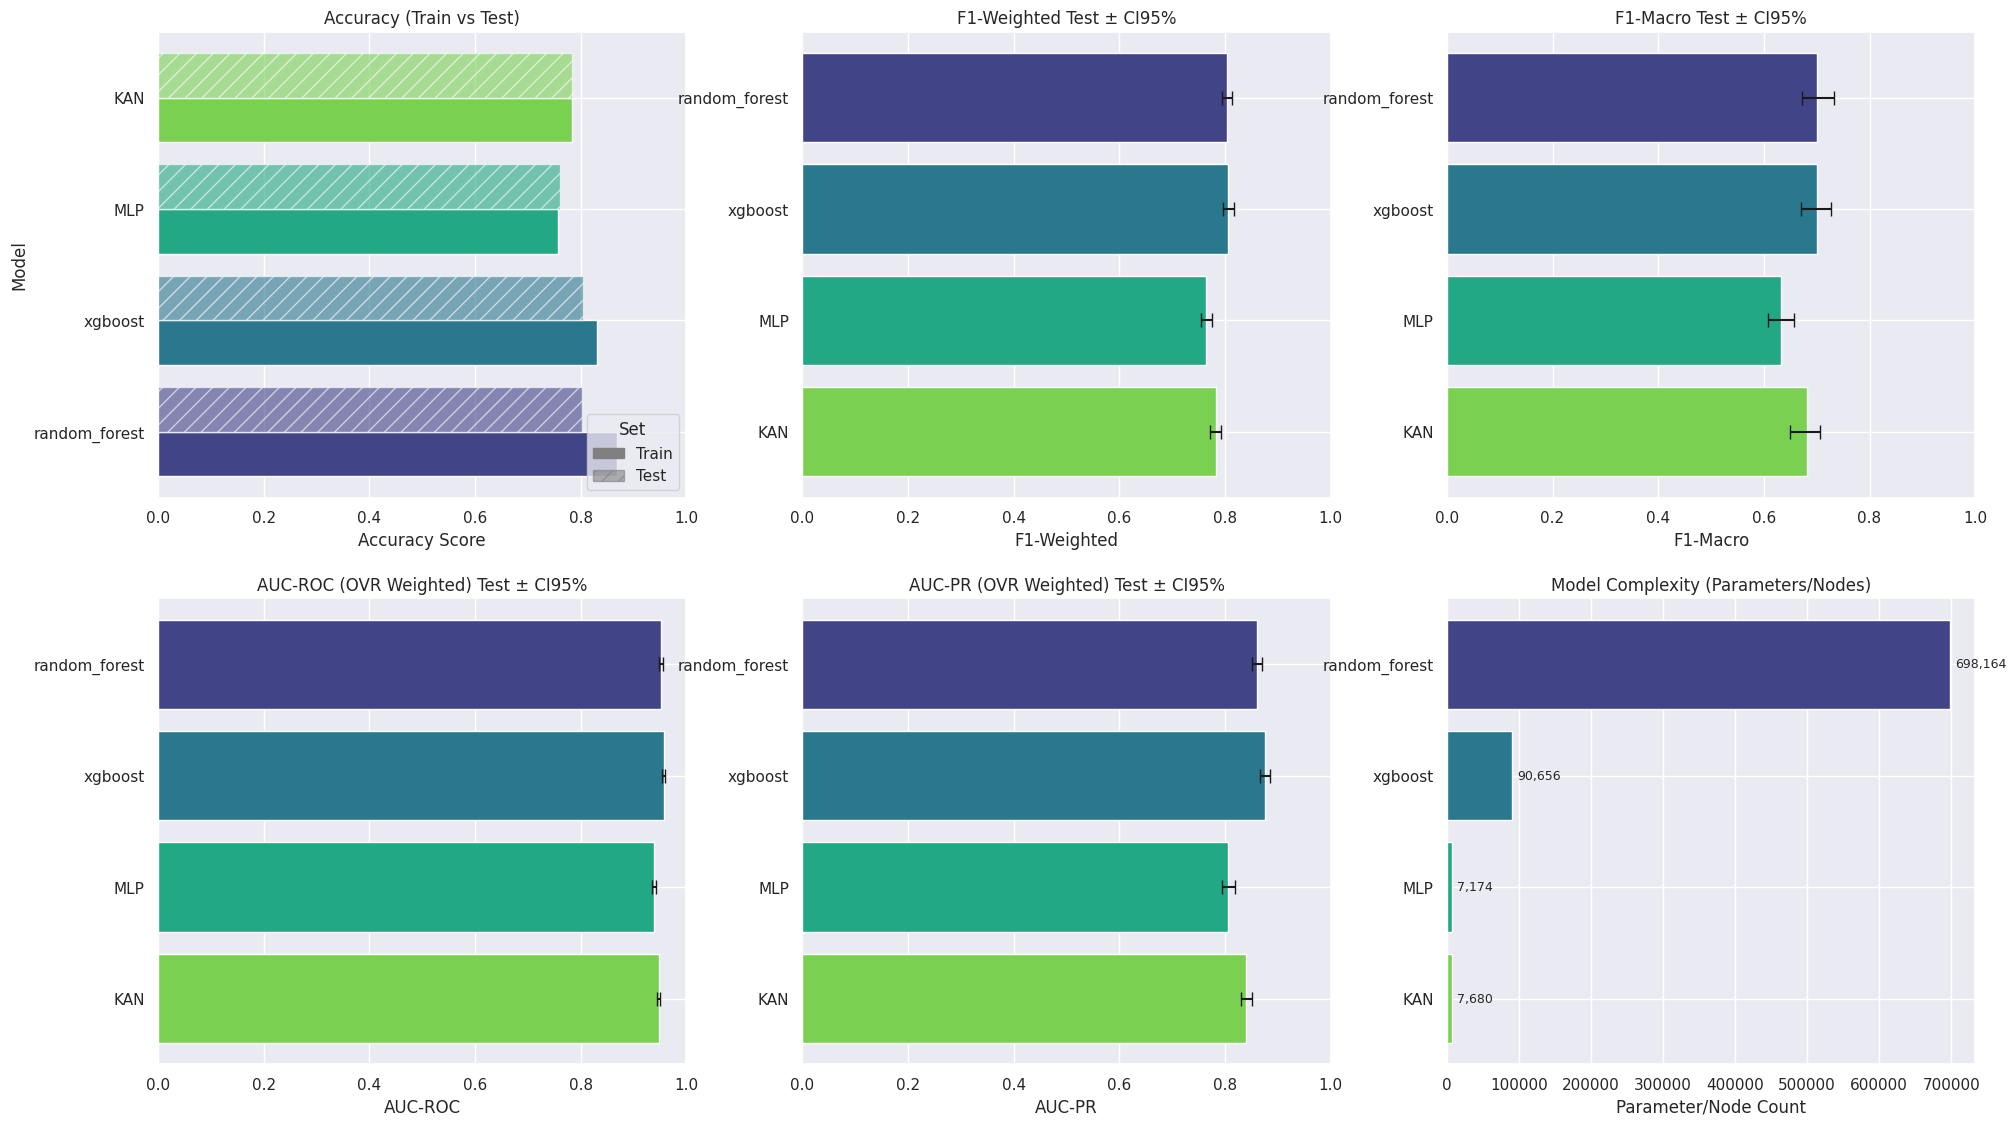

In [46]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'Model', 'Param_Count',
        'Accuracy_Train', 'Accuracy_Test',
        'F1_Weighted_Train', 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
        'F1_Macro_Train', 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
        'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
        'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [47]:
# 1) Define metrics and their optimization direction
metrics = {
    'Accuracy_Test': 'max',
    'F1_Weighted_Test': 'max',
    'F1_Macro_Test': 'max',
    'AUC_ROC_OVR_Weighted': 'max',
    'AUC_PR_OVR_Weighted': 'max'
}

# 2) Build ranking DataFrame
df_ranks = estimator_scores_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calculate ranks for performance metrics
for metric, direction in metrics.items():
    if direction == 'max':
        # Per metriche 'max' (più alto è meglio), rank in ordine decrescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # Per metriche 'min' (più basso è meglio), rank in ordine crescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# Calculate complexity rank (lower parameter count is better)
ranks['Complexity_rank'] = df_ranks['Param_Count'].rank(ascending=True, method='average')

# 3) Calculate weighted scores
# Performance score (average of performance ranks)
performance_cols = [col for col in ranks.columns if col.endswith('_rank') and col != 'Complexity_rank']
ranks['performance_score'] = ranks[performance_cols].mean(axis=1)

# Method 1: Equal weighting
ranks['equal_weight_score'] = ranks['performance_score'] + ranks['Complexity_rank']

# Method 2: Complexity heavily weighted (complexity counts 2x)
ranks['complexity_weighted_score'] = ranks['performance_score'] + (2 * ranks['Complexity_rank'])

# Method 3: Extreme complexity weighting (complexity counts 3x)
ranks['extreme_complexity_score'] = ranks['performance_score'] + (3 * ranks['Complexity_rank'])

# Method 4: Pareto efficiency approach (performance vs complexity)
# Normalize scores to [0,1] for fair comparison
performance_norm = (ranks['performance_score'] - ranks['performance_score'].min()) / (ranks['performance_score'].max() - ranks['performance_score'].min())
complexity_norm = (ranks['Complexity_rank'] - ranks['Complexity_rank'].min()) / (ranks['Complexity_rank'].max() - ranks['Complexity_rank'].min())
ranks['pareto_score'] = 0.4 * performance_norm + 0.6 * complexity_norm  # 60% weight on complexity

# Display results for each method
methods = {
    'Equal Weight (1:1)': 'equal_weight_score',
    'Complexity Weighted (1:2)': 'complexity_weighted_score',
    'Extreme Complexity (1:3)': 'extreme_complexity_score',
    'Pareto Approach (40:60)': 'pareto_score'
}

results_summary = pd.DataFrame(index=df_ranks.index)
results_summary['Performance_Score'] = ranks['performance_score']
results_summary['Complexity_Rank'] = ranks['Complexity_rank']
results_summary['Param_Count'] = df_ranks['Param_Count']

for method_name, score_col in methods.items():
    best_model = ranks[score_col].idxmin() if 'pareto' not in score_col else ranks[score_col].idxmin()
    best_score = ranks.loc[best_model, score_col]
    results_summary[method_name] = ranks[score_col]
    print(f"{method_name:25} -> {best_model:15} (score: {best_score:.3f})")

print("\n" + "="*70)
print("DETAILED RANKING TABLE")
print("="*70)

# Create comprehensive ranking table
ranking_display = pd.DataFrame(index=df_ranks.index)
ranking_display['Param_Count'] = df_ranks['Param_Count'].astype(int)
ranking_display['Avg_Performance'] = ranks['performance_score'].round(2)
ranking_display['Complexity_Rank'] = ranks['Complexity_rank'].astype(int)

for method_name, score_col in methods.items():
    ranking_display[f'{method_name.split()[0]}_Rank'] = ranks[score_col].rank().astype(int)

# Sort by complexity-weighted score (our recommended approach)
ranking_display_sorted = ranking_display.sort_values('Complexity_Rank')
display(ranking_display_sorted)

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Our recommended model (complexity weighted approach)
recommended_model = ranks['complexity_weighted_score'].idxmin()
recommended_score = ranks.loc[recommended_model, 'complexity_weighted_score']
recommended_params = df_ranks.loc[recommended_model, 'Param_Count']
recommended_f1 = df_ranks.loc[recommended_model, 'F1_Weighted_Test']

print(f"   RECOMMENDED MODEL: {recommended_model}")
print(f"   Reason: Best balance between performance and complexity")
print(f"   Parameters: {int(recommended_params):,}")
print(f"   F1-Weighted Score: {recommended_f1:.4f}")
print(f"   Complexity-Weighted Rank Score: {recommended_score:.3f}")

# Show top 3 models for comparison
print(f"\n  TOP 3 MODELS (Complexity-Weighted Ranking):")
top_3 = ranks.sort_values('complexity_weighted_score').head(3)
for i, (model, row) in enumerate(top_3.iterrows(), 1):
    params = int(df_ranks.loc[model, 'Param_Count'])
    f1_value = df_ranks.loc[model, 'F1_Weighted_Test']
    print(f"   {i}. {model:15} | Params: {params:>8,} | F1: {f1_value:.4f} | Score: {row['complexity_weighted_score']:.3f}")

Equal Weight (1:1)        -> xgboost         (score: 4.200)
Complexity Weighted (1:2) -> MLP             (score: 6.000)
Extreme Complexity (1:3)  -> MLP             (score: 7.000)
Pareto Approach (40:60)   -> xgboost         (score: 0.400)

DETAILED RANKING TABLE


,Param_Count,Avg_Performance,Complexity_Rank,Equal_Rank,Extreme_Rank,Pareto_Rank
Model,,,,,,
MLP,7174,4.0,1,2,1,2
KAN,7680,3.0,2,2,2,3
xgboost,90656,1.2,3,1,3,1
random_forest,698164,1.8,4,4,4,4



RECOMMENDATION
   RECOMMENDED MODEL: MLP
   Reason: Best balance between performance and complexity
   Parameters: 7,174
   F1-Weighted Score: 0.7645
   Complexity-Weighted Rank Score: 6.000

  TOP 3 MODELS (Complexity-Weighted Ranking):
   1. MLP             | Params:    7,174 | F1: 0.7645 | Score: 6.000
   2. KAN             | Params:    7,680 | F1: 0.7823 | Score: 7.000
   3. xgboost         | Params:   90,656 | F1: 0.8065 | Score: 7.200


# Ablation Study MLP e KAN

=== STANDALONE MLP/KAN PRUNING STUDY ===

=== Standalone L1 Pruning Study for MLP ===
NOTA: MLP è un modello MLP standalone
Total Parameters: 7,174

Testing MLP pruning ratio: 0.0000
  Sparsity: 0.000
  Active params: 7,174 / 7,174
  Compression: 1.00x
  Accuracy: 0.7609
  F1-Weighted: 0.7645

Testing MLP pruning ratio: 0.1000


  Applied L1 pruning to standalone MLP with ratio: 0.100
  Sparsity: 0.100
  Active params: 6,457 / 7,174
  Compression: 1.11x
  Accuracy: 0.7602
  F1-Weighted: 0.7641

Testing MLP pruning ratio: 0.2000
  Applied L1 pruning to standalone MLP with ratio: 0.200
  Sparsity: 0.200
  Active params: 5,739 / 7,174
  Compression: 1.25x
  Accuracy: 0.7605
  F1-Weighted: 0.7650

Testing MLP pruning ratio: 0.3000
  Applied L1 pruning to standalone MLP with ratio: 0.300
  Sparsity: 0.300
  Active params: 5,022 / 7,174
  Compression: 1.43x
  Accuracy: 0.7653
  F1-Weighted: 0.7674

Testing MLP pruning ratio: 0.5000
  Applied L1 pruning to standalone MLP with ratio: 0.500
  Sparsity: 0.500
  Active params: 3,587 / 7,174
  Compression: 2.00x
  Accuracy: 0.7603
  F1-Weighted: 0.7643

Testing MLP pruning ratio: 0.7000


  Applied L1 pruning to standalone MLP with ratio: 0.700
  Sparsity: 0.700
  Active params: 2,152 / 7,174
  Compression: 3.33x
  Accuracy: 0.7128
  F1-Weighted: 0.7183

Testing MLP pruning ratio: 0.8000
  Applied L1 pruning to standalone MLP with ratio: 0.800
  Sparsity: 0.800
  Active params: 1,435 / 7,174
  Compression: 5.00x
  Accuracy: 0.7301
  F1-Weighted: 0.7391

Testing MLP pruning ratio: 0.9000
  Applied L1 pruning to standalone MLP with ratio: 0.900
  Sparsity: 0.900
  Active params: 717 / 7,174
  Compression: 10.01x
  Accuracy: 0.7094
  F1-Weighted: 0.6891

Testing MLP pruning ratio: 0.9500
  Applied L1 pruning to standalone MLP with ratio: 0.950
  Sparsity: 0.950
  Active params: 359 / 7,174
  Compression: 19.98x
  Accuracy: 0.6439
  F1-Weighted: 0.5510

=== Standalone L1 Pruning Study for KAN ===
NOTA: KAN è un modello KAN standalone
Total Parameters: 7,680

Testing KAN pruning ratio: 0.0000


  Sparsity: 0.000
  Active params: 7,680 / 7,680
  Compression: 1.00x
  Accuracy: 0.7839
  F1-Weighted: 0.7823

Testing KAN pruning ratio: 0.1000
  Applied L1 pruning to standalone KAN with ratio: 0.100
  Sparsity: 0.113
  Active params: 7,776 / 7,680
  Compression: 0.99x
  Accuracy: 0.7839
  F1-Weighted: 0.7822

Testing KAN pruning ratio: 0.2000
  Applied L1 pruning to standalone KAN with ratio: 0.200
  Sparsity: 0.225
  Active params: 6,912 / 7,680
  Compression: 1.11x
  Accuracy: 0.7836
  F1-Weighted: 0.7819

Testing KAN pruning ratio: 0.3000
  Applied L1 pruning to standalone KAN with ratio: 0.300


  Sparsity: 0.338
  Active params: 6,048 / 7,680
  Compression: 1.27x
  Accuracy: 0.7850
  F1-Weighted: 0.7828

Testing KAN pruning ratio: 0.5000
  Applied L1 pruning to standalone KAN with ratio: 0.500
  Sparsity: 0.562
  Active params: 4,320 / 7,680
  Compression: 1.78x
  Accuracy: 0.7746
  F1-Weighted: 0.7728

Testing KAN pruning ratio: 0.7000
  Applied L1 pruning to standalone KAN with ratio: 0.700
  Sparsity: 0.787
  Active params: 2,592 / 7,680
  Compression: 2.96x
  Accuracy: 0.7661
  F1-Weighted: 0.7710

Testing KAN pruning ratio: 0.8000
  Applied L1 pruning to standalone KAN with ratio: 0.800


  Sparsity: 0.900
  Active params: 1,728 / 7,680
  Compression: 4.44x
  Accuracy: 0.7473
  F1-Weighted: 0.7574

Testing KAN pruning ratio: 0.9000
  Applied L1 pruning to standalone KAN with ratio: 0.900
  Sparsity: 1.012
  Active params: 864 / 7,680
  Compression: 8.89x
  Accuracy: 0.7030
  F1-Weighted: 0.7117

Testing KAN pruning ratio: 0.9500
  Applied L1 pruning to standalone KAN with ratio: 0.950
  Sparsity: 1.069
  Active params: 432 / 7,680
  Compression: 17.78x
  Accuracy: 0.6777
  F1-Weighted: 0.6875


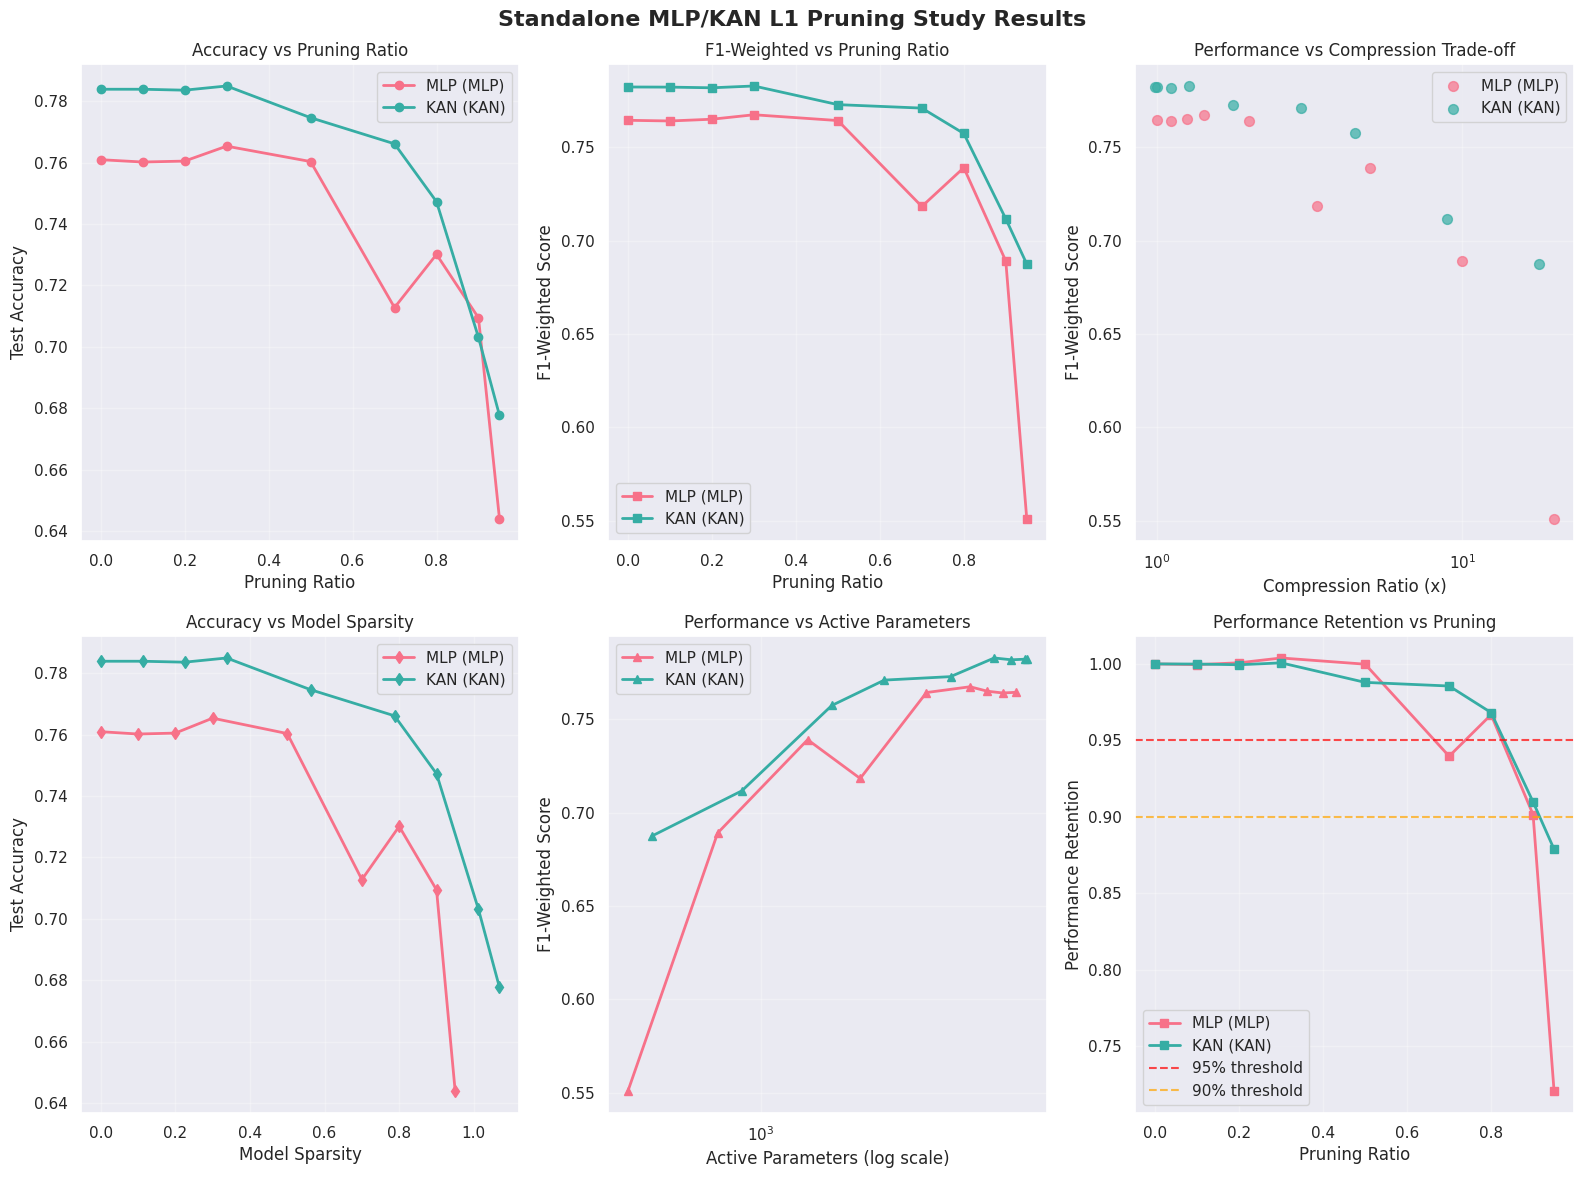


STANDALONE MLP/KAN L1 PRUNING STUDY - DETAILED REPORT

MLP Results:
--------------------------------------------------
Model Type: MLP
Total Parameters: 7,174
Baseline F1-Weighted: 0.7645
Significant degradation starts at: 70.0% pruning

Best trade-off point:
  Pruning ratio: 50.0%
  Compression: 2.0x
  F1_Weighted: 0.7643
  Performance loss: 0.0%

Maximum compression achieved: 20.0x

KAN Results:
--------------------------------------------------
Model Type: KAN
Total Parameters: 7,680
Baseline F1-Weighted: 0.7823
Significant degradation starts at: 90.0% pruning

Best trade-off point:
  Pruning ratio: 70.0%
  Compression: 3.0x
  F1_Weighted: 0.7710
  Performance loss: 1.4%

Maximum compression achieved: 17.8x

COMPARATIVE SUMMARY TABLE - STANDALONE MODELS
Model Type Pruning_Ratio Compression F1_Score Perf_Loss
  MLP  MLP           30%        1.4x   0.7674     -0.4%
  MLP  MLP           50%        2.0x   0.7643      0.0%
  MLP  MLP           70%        3.3x   0.7183      6.0%
  MLP  M

,model_name,model_type,pruning_ratio,sparsity,total_params,active_params,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,MLP,MLP,0.00,0.000000,7174,7174,1.000000,0.760942,0.764454,0.632376,0.939735,0.805728
1,MLP,MLP,0.10,0.099944,7174,6457,1.111042,0.760182,0.764093,0.632270,0.939670,0.805881
2,MLP,MLP,0.20,0.200028,7174,5739,1.250044,0.760486,0.765027,0.629134,0.939562,0.804136
3,MLP,MLP,0.30,0.299972,7174,5022,1.428515,0.765350,0.767423,0.638853,0.939183,0.802617
4,MLP,MLP,0.50,0.500000,7174,3587,2.000000,0.760334,0.764319,0.628866,0.936809,0.795955
5,MLP,MLP,0.70,0.700028,7174,2152,3.333643,0.712766,0.718303,0.589043,0.931516,0.795829
6,MLP,MLP,0.80,0.799972,7174,1435,4.999303,0.730091,0.739067,0.625030,0.939747,0.804045
7,MLP,MLP,0.90,0.900056,7174,717,10.005579,0.709422,0.689107,0.446357,0.924893,0.748957
8,MLP,MLP,0.95,0.949958,7174,359,19.983287,0.643921,0.550974,0.357334,0.898524,0.684812
9,KAN,KAN,0.00,0.000000,7680,7680,1.000000,0.783891,0.782290,0.681209,0.947651,0.840296


In [48]:
class StandalonePruningAblationStudy:
    def __init__(self, device='cpu'):
        self.device = device
        self.pruning_results = []

    def get_model_sparsity(self, model):
        """Calcola la sparsità per modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                # Calcola parametri totali KAN usando count_params esistente
                total_params = count_params(model)

                # Conta i parametri zero nella componente KAN
                zero_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        # Accedi ai coefficienti spline (coef parameter)
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            zero_params += float(torch.sum(layer.coef == 0))

                return zero_params / total_params if total_params > 0 else 0.0

            except Exception as e:
                print(f"  Error calculating KAN sparsity: {e}")
                return 0.0

        else:
            # Modello MLP standalone
            zero_params = 0
            total_params = count_params(model)

            # Conta parametri zero in tutti i layer Linear
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        zero_params += float(torch.sum(module.weight == 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        zero_params += float(torch.sum(module.bias == 0))

            return zero_params / total_params if total_params > 0 else 0.0

    def count_active_parameters(self, model):
        """Conta i parametri attivi nei modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                active_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            active_params += float(torch.sum(layer.coef != 0))

                return int(active_params)
            except:
                return count_params(model)

        else:
            # Modello MLP standalone
            active_params = 0
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        active_params += float(torch.sum(module.weight != 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        active_params += float(torch.sum(module.bias != 0))

            return int(active_params)


    def apply_l1_pruning_standalone(self, model, pruning_ratio):
        """Applica L1 norm pruning a modelli MLP/KAN standalone"""
        pruned_model = copy.deepcopy(model)

        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                if pruning_ratio == 0.0:
                    return pruned_model

                # Colleziona tutti i parametri KAN per L1 pruning globale
                kan_modules_to_prune = []
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = pruned_model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            temp_module = torch.nn.Linear(1, 1, bias=False)
                            temp_module.weight = torch.nn.Parameter(layer.coef.view(-1, 1))
                            kan_modules_to_prune.append((temp_module, 'weight'))


                if kan_modules_to_prune:
                    # Applica L1 pruning globale sui parametri KAN
                    prune.global_unstructured(
                        kan_modules_to_prune,
                        pruning_method=prune.L1Unstructured,
                        amount=pruning_ratio,
                    )

                    # Applica le maschere ai coefficienti originali
                    idx = 0
                    for i in range(len(model.width) - 1):
                        if i < len(model.act_fun):
                            layer = pruned_model.act_fun[i]
                            if hasattr(layer, 'coef') and layer.coef is not None:
                                original_shape = layer.coef.shape
                                mask = kan_modules_to_prune[idx][0].weight_mask.view(original_shape)
                                layer.coef.data = layer.coef.data * mask
                                idx += 1

                    # Rimuove le maschere temporanee
                    for module, param_name in kan_modules_to_prune:
                        prune.remove(module, param_name)

                print(f"  Applied L1 pruning to standalone KAN with ratio: {pruning_ratio:.3f}")
                return pruned_model

            except Exception as e:
                print(f"  Error during KAN L1 pruning: {e}")
                return model

        else:
            # Modello MLP standalone
            modules_to_prune = []

            # Colleziona tutti i layer Linear
            for module in pruned_model.modules():
                if isinstance(module, torch.nn.Linear):
                    modules_to_prune.append((module, 'weight'))
                    if hasattr(module, 'bias') and module.bias is not None:
                        modules_to_prune.append((module, 'bias'))

            if modules_to_prune:
                # Applica L1 pruning globale
                prune.global_unstructured(
                    modules_to_prune,
                    pruning_method=prune.L1Unstructured,
                    amount=pruning_ratio,
                )

                # Rende permanente il pruning
                for module, param_name in modules_to_prune:
                    prune.remove(module, param_name)

            print(f"  Applied L1 pruning to standalone MLP with ratio: {pruning_ratio:.3f}")
            return pruned_model


    def evaluate_pruned_model(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello pruned su dati tabulari"""
        # Ensure the model is on the correct device
        model.to(self.device)
        model.eval()

        # Converte in tensori, se necessario, e sposta sul device
        if not isinstance(X_test, torch.Tensor):
            X_test = torch.FloatTensor(X_test).to(self.device)
        else:
            X_test = X_test.to(self.device)

        if not isinstance(y_test, torch.Tensor):
            y_test = torch.LongTensor(y_test).to(self.device)
        else:
             y_test = y_test.to(self.device)

        if not isinstance(X_train, torch.Tensor):
            X_train = torch.FloatTensor(X_train).to(self.device)
        else:
            X_train = X_train.to(self.device)

        if not isinstance(y_train, torch.Tensor):
            y_train = torch.LongTensor(y_train).to(self.device)
        else:
            y_train = y_train.to(self.device)


        # Predizioni
        with torch.no_grad():
            # Test set
            outputs_test = model(X_test)
            y_pred_test = torch.argmax(outputs_test, dim=1)
            y_proba_test = F.softmax(outputs_test, dim=1)

            # Train set
            outputs_train = model(X_train)
            y_pred_train = torch.argmax(outputs_train, dim=1)

        # Converte in NumPy per le metriche
        y_pred_test = y_pred_test.cpu().numpy()
        y_true_test = y_test.cpu().numpy()
        y_proba_test = y_proba_test.cpu().numpy()
        y_pred_train = y_pred_train.cpu().numpy()
        y_true_train = y_train.cpu().numpy()


        # Calcola metriche
        accuracy = accuracy_score(y_true_test, y_pred_test)
        f1_weighted = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC
        try:
            auc_roc = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr = average_precision_score(pd.get_dummies(y_true_test), y_proba_test, average='weighted')
        except ValueError:
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }


    def run_standalone_pruning_study(self, model, model_name, X_test, y_test, X_train, y_train,
                                   pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]):
        """
        Conduce lo studio di ablazione con L1 pruning su modelli standalone MLP/KAN
        """
        print(f"\n=== Standalone L1 Pruning Study for {model_name} ===")

        # Determina il tipo di modello
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            model_type = "KAN"
            print(f"NOTA: {model_name} è un modello KAN standalone")
        else:
            model_type = "MLP"
            print(f"NOTA: {model_name} è un modello MLP standalone")

        # Parametri totali usando count_params
        total_params = count_params(model)
        print(f"Total Parameters: {total_params:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting {model_type} pruning ratio: {pruning_ratio:.4f}")

            if pruning_ratio == 0.0:
                # Modello originale
                pruned_model = model
                sparsity = 0.0
                active_params = total_params
            else:
                # Applica L1 pruning
                pruned_model = self.apply_l1_pruning_standalone(model, pruning_ratio)
                pruned_model.to(self.device)
                sparsity = self.get_model_sparsity(pruned_model)
                active_params = self.count_active_parameters(pruned_model)

            # Valuta prestazioni
            metrics = self.evaluate_pruned_model(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Calcola statistiche di compressione
            compression_ratio = total_params / active_params if active_params > 0 else float('inf')

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': model_type,
                'pruning_ratio': pruning_ratio,
                'sparsity': sparsity,
                'total_params': total_params,
                'active_params': active_params,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Sparsity: {sparsity:.3f}")
            print(f"  Active params: {active_params:,} / {total_params:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")


    def plot_standalone_pruning_results(self, figsize=(16, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli standalone
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Standalone MLP/KAN L1 Pruning Study Results', fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("husl", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: Performance vs Compression Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({model_type})', color=colors[i], s=50, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 4: Sparsity vs Performance
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['sparsity'], model_data['accuracy'],
                   marker='d', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Model Sparsity')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Model Sparsity')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 5: Active Parameters vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.semilogx(model_data['active_params'], model_data['f1_weighted'],
                       marker='^', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Active Parameters (log scale)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Active Parameters')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: Performance Retention
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            model_type = model_data.iloc[0]['model_type']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='s', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_standalone_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning standalone
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("STANDALONE MLP/KAN L1 PRUNING STUDY - DETAILED REPORT")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_params = baseline_row['total_params']
            model_type = baseline_row['model_type']

            print(f"Model Type: {model_type}")
            print(f"Total Parameters: {total_params:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - STANDALONE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]
            model_type = baseline['model_type']

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Type': model_type,
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

print("=== STANDALONE MLP/KAN PRUNING STUDY ===")

standalone_pruning_study = StandalonePruningAblationStudy(device=device)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_mlp,
    model_name='MLP',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_kan,
    model_name='KAN',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.plot_standalone_pruning_results()
standalone_pruning_study.generate_standalone_pruning_report()

results_df = pd.DataFrame(standalone_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(results_df)} rows")
print("\nPruning results:")
display(results_df)

# Ablation Study RandomForest e XGBoost

In [49]:
# Ablation Study Ensemble Pruning: Random Forest e XGBoost

class EnsemblePruningAblationStudy:
    def __init__(self):
        self.pruning_results = []

    def rank_based_pruning_rf(self, rf_model, pruning_ratio):
        """
        Implementa Rank-Based Pruning per Random Forest.
        Rimuove gli alberi con le feature importance più basse.
        """
        if pruning_ratio == 0.0:
            return rf_model, list(range(len(rf_model.estimators_)))

        # Calcola l'importanza di ogni albero basata sulla media delle feature importance
        tree_importances = []
        for i, tree in enumerate(rf_model.estimators_):
            # L'importanza dell'albero è la somma delle importanze delle sue feature
            tree_importance = np.sum(tree.feature_importances_)
            tree_importances.append((i, tree_importance))

        # Ordina gli alberi per importanza (decrescente)
        tree_importances.sort(key=lambda x: x[1], reverse=True)

        # Calcola quanti alberi mantenere
        n_trees_to_keep = max(1, int(len(rf_model.estimators_) * (1 - pruning_ratio)))

        # Seleziona gli indici degli alberi da mantenere
        selected_indices = [idx for idx, _ in tree_importances[:n_trees_to_keep]]
        selected_indices.sort()  # Mantieni l'ordine originale

        # Crea un nuovo modello con solo gli alberi selezionati
        pruned_rf = copy.deepcopy(rf_model)
        pruned_rf.estimators_ = [rf_model.estimators_[i] for i in selected_indices]
        pruned_rf.n_estimators = len(selected_indices)

        return pruned_rf, selected_indices

    def cumulative_pruning_xgb(self, xgb_model, pruning_ratio):
        """
        Implementa Cumulative Pruning per XGBoost.
        Mantiene solo le prime iterazioni di boosting in base al pruning_ratio.
        """
        if pruning_ratio == 0.0:
            return xgb_model, list(range(xgb_model.n_estimators))

        # Ottieni il booster
        original_booster = xgb_model.get_booster()

        # Calcola il numero di alberi da mantenere
        total_trees = xgb_model.n_estimators
        num_classes = xgb_model.n_classes_
        total_rounds = total_trees // num_classes
        keep_rounds = max(1, int(total_rounds * (1 - pruning_ratio)))
        n_keep = keep_rounds * num_classes

        # Crea una copia del modello originale
        pruned_model = copy.deepcopy(xgb_model)
        pruned_model.n_estimators = n_keep

        def predict_pruned(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            predicted_labels = np.argmax(raw_predictions, axis=1)
            return predicted_labels

        def predict_proba(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            proba = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
            return proba

        pruned_model.predict = types.MethodType(predict_pruned, pruned_model)
        pruned_model.predict_proba = types.MethodType(predict_proba, pruned_model)

        selected_indices = list(range(n_keep))
        return pruned_model, selected_indices

    def evaluate_pruned_ensemble(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello ensemble pruned"""

        # Previsioni
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Calcola metriche
        accuracy = accuracy_score(y_test, y_pred_test)
        f1_weighted = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC (se il modello supporta predict_proba)
        try:
            if hasattr(model, 'predict_proba'):
                y_proba_test = model.predict_proba(X_test)
                auc_roc = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
                auc_pr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')
            else:
                auc_roc = np.nan
                auc_pr = np.nan
        except (ValueError, AttributeError):
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }

    def run_rf_pruning_study(self, rf_model, model_name, X_test, y_test, X_train, y_train,
                           pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Rank-Based Pruning su Random Forest
        """
        print(f"\n=== Rank-Based Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = len(rf_model.estimators_)
        print(f"Total Trees: {total_trees:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting RF pruning ratio: {pruning_ratio:.2f}")

            # Applica rank-based pruning
            pruned_model, selected_indices = self.rank_based_pruning_rf(rf_model, pruning_ratio)

            # Calcola statistiche
            remaining_trees = len(selected_indices)
            compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

            # Valuta prestazioni
            metrics = self.evaluate_pruned_ensemble(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': 'Random Forest',
                'pruning_method': 'Rank-Based',
                'pruning_ratio': pruning_ratio,
                'total_trees': total_trees,
                'remaining_trees': remaining_trees,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

    def run_xgb_pruning_study(self, xgb_model, model_name, X_test, y_test, X_train, y_train,
                            pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Cumulative Pruning su XGBoost
        """
        print(f"\n=== Cumulative Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = xgb_model.n_estimators
        print(f"Total Trees: {total_trees:,}")
        print(f"Number of Classes: {xgb_model.n_classes_}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting XGB pruning ratio: {pruning_ratio:.2f}")

            try:
                # Applica cumulative pruning
                pruned_model, selected_indices = self.cumulative_pruning_xgb(xgb_model, pruning_ratio)

                # Calcola statistiche
                remaining_trees = len(selected_indices)
                compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

                # Valuta prestazioni
                metrics = self.evaluate_pruned_ensemble(
                    pruned_model, model_name, X_test, y_test, X_train, y_train
                )

                # Salva risultati
                result = {
                    'model_name': model_name,
                    'model_type': 'XGBoost',
                    'pruning_method': 'Cumulative',
                    'pruning_ratio': pruning_ratio,
                    'total_trees': total_trees,
                    'remaining_trees': remaining_trees,
                    'compression_ratio': compression_ratio,
                    'accuracy': metrics['accuracy'],
                    'f1_weighted': metrics['f1_weighted'],
                    'f1_macro': metrics['f1_macro'],
                    'auc_roc': metrics['auc_roc'],
                    'auc_pr': metrics['auc_pr']
                }

                self.pruning_results.append(result)

                print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
                print(f"  Compression: {compression_ratio:.2f}x")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

            except Exception as e:
                print(f"  Error during XGB pruning at ratio {pruning_ratio}: {e}")
                continue

    def plot_ensemble_pruning_results(self, figsize=(18, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli ensemble
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(3, 3, figsize=figsize)
        fig.suptitle('Ensemble Pruning Study Results - Random Forest & XGBoost',
                     fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("Set1", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='s', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: F1-Macro vs Pruning Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_macro'],
                   marker='^', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Macro Score')
        ax.set_title('F1-Macro vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 4: Performance vs Compression Ratio
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({method})', color=colors[i], s=60, alpha=0.7)
        ax.set_xlabel('Compression Ratio (x)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression Trade-off')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 5: Remaining Trees vs Performance
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.semilogx(model_data['remaining_trees'], model_data['accuracy'],
                       marker='d', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Remaining Trees (log scale)')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Accuracy vs Remaining Trees')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: AUC-ROC vs Pruning Ratio
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            # Filtra i valori NaN per AUC
            valid_mask = ~np.isnan(model_data['auc_roc'])
            if valid_mask.any():
                valid_data = model_data[valid_mask]
                ax.plot(valid_data['pruning_ratio'], valid_data['auc_roc'],
                       marker='*', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('AUC-ROC Score')
        ax.set_title('AUC-ROC vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 7: Performance Retention
        ax = axes[2, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='s', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 8: Trees Reduction vs Performance Loss
        ax = axes[2, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_loss = (baseline_f1 - model_data['f1_weighted']) / baseline_f1 * 100
            trees_reduction = (1 - model_data['remaining_trees'] / model_data['total_trees']) * 100
            ax.plot(trees_reduction, performance_loss,
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Trees Reduction (%)')
        ax.set_ylabel('Performance Loss (%)')
        ax.set_title('Trees Reduction vs Performance Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 9: Efficiency Comparison
        ax = axes[2, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            baseline_trees = model_data.iloc[0]['total_trees']
            baseline_f1 = model_data.iloc[0]['f1_weighted']

            # Calcola l'efficienza come F1-score per albero
            efficiency = model_data['f1_weighted'] / (model_data['remaining_trees'] / baseline_trees)
            ax.plot(model_data['pruning_ratio'], efficiency,
                   marker='x', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Efficiency (F1/Tree Fraction)')
        ax.set_title('Model Efficiency vs Pruning')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_ensemble_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning ensemble
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("ENSEMBLE PRUNING STUDY - DETAILED REPORT")
        print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_trees = baseline_row['total_trees']
            model_type = baseline_row['model_type']
            pruning_method = baseline_row['pruning_method']

            print(f"Model Type: {model_type}")
            print(f"Pruning Method: {pruning_method}")
            print(f"Total Trees: {total_trees:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Trees: {best_tradeoff['remaining_trees']:,} / {total_trees:,}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    trees_reduction = ((baseline['total_trees'] - closest['remaining_trees']) / baseline['total_trees']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Method': baseline['pruning_method'],
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Trees_Kept': f"{closest['remaining_trees']:,}",
                        'Trees_Reduction': f"{trees_reduction:.0f}%",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

ENSEMBLE PRUNING ABLATION STUDY
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning
Random Forest model extracted successfully

=== Rank-Based Pruning Study for Random Forest ===
Total Trees: 200

Testing RF pruning ratio: 0.00


  Remaining trees: 200 / 200
  Compression: 1.00x
  Accuracy: 0.0805
  F1-Weighted: 0.0741

Testing RF pruning ratio: 0.10


  Remaining trees: 180 / 200
  Compression: 1.11x
  Accuracy: 0.0801
  F1-Weighted: 0.0734

Testing RF pruning ratio: 0.20


  Remaining trees: 160 / 200
  Compression: 1.25x
  Accuracy: 0.0805
  F1-Weighted: 0.0747

Testing RF pruning ratio: 0.30


  Remaining trees: 140 / 200
  Compression: 1.43x
  Accuracy: 0.0812
  F1-Weighted: 0.0751

Testing RF pruning ratio: 0.40


  Remaining trees: 120 / 200
  Compression: 1.67x
  Accuracy: 0.0822
  F1-Weighted: 0.0757

Testing RF pruning ratio: 0.50


  Remaining trees: 100 / 200
  Compression: 2.00x
  Accuracy: 0.0824
  F1-Weighted: 0.0760

Testing RF pruning ratio: 0.60


  Remaining trees: 80 / 200
  Compression: 2.50x
  Accuracy: 0.0834
  F1-Weighted: 0.0770

Testing RF pruning ratio: 0.70


  Remaining trees: 60 / 200
  Compression: 3.33x
  Accuracy: 0.0833
  F1-Weighted: 0.0770

Testing RF pruning ratio: 0.80


  Remaining trees: 39 / 200
  Compression: 5.13x
  Accuracy: 0.0854
  F1-Weighted: 0.0803

Testing RF pruning ratio: 0.90


  Remaining trees: 19 / 200
  Compression: 10.53x
  Accuracy: 0.0845
  F1-Weighted: 0.0799

Testing RF pruning ratio: 0.95


  Remaining trees: 10 / 200
  Compression: 20.00x
  Accuracy: 0.0878
  F1-Weighted: 0.0855
XGBoost model extracted successfully

=== Cumulative Pruning Study for XGBoost ===
Total Trees: 300
Number of Classes: 6

Testing XGB pruning ratio: 0.00


  Remaining trees: 300 / 300
  Compression: 1.00x
  Accuracy: 0.8052
  F1-Weighted: 0.8065

Testing XGB pruning ratio: 0.10


  Remaining trees: 270 / 300
  Compression: 1.11x
  Accuracy: 0.8041
  F1-Weighted: 0.8058

Testing XGB pruning ratio: 0.20


  Remaining trees: 240 / 300
  Compression: 1.25x
  Accuracy: 0.8053
  F1-Weighted: 0.8075

Testing XGB pruning ratio: 0.30


  Remaining trees: 210 / 300
  Compression: 1.43x
  Accuracy: 0.8015
  F1-Weighted: 0.8042

Testing XGB pruning ratio: 0.40


  Remaining trees: 180 / 300
  Compression: 1.67x
  Accuracy: 0.7986
  F1-Weighted: 0.8019

Testing XGB pruning ratio: 0.50


  Remaining trees: 150 / 300
  Compression: 2.00x
  Accuracy: 0.7953
  F1-Weighted: 0.7991

Testing XGB pruning ratio: 0.60


  Remaining trees: 120 / 300
  Compression: 2.50x
  Accuracy: 0.7929
  F1-Weighted: 0.7972

Testing XGB pruning ratio: 0.70


  Remaining trees: 90 / 300
  Compression: 3.33x
  Accuracy: 0.7889
  F1-Weighted: 0.7939

Testing XGB pruning ratio: 0.80
  Remaining trees: 54 / 300
  Compression: 5.56x
  Accuracy: 0.7837
  F1-Weighted: 0.7897

Testing XGB pruning ratio: 0.90


  Remaining trees: 24 / 300
  Compression: 12.50x
  Accuracy: 0.7790
  F1-Weighted: 0.7856

Testing XGB pruning ratio: 0.95
  Remaining trees: 12 / 300
  Compression: 25.00x
  Accuracy: 0.7774
  F1-Weighted: 0.7843


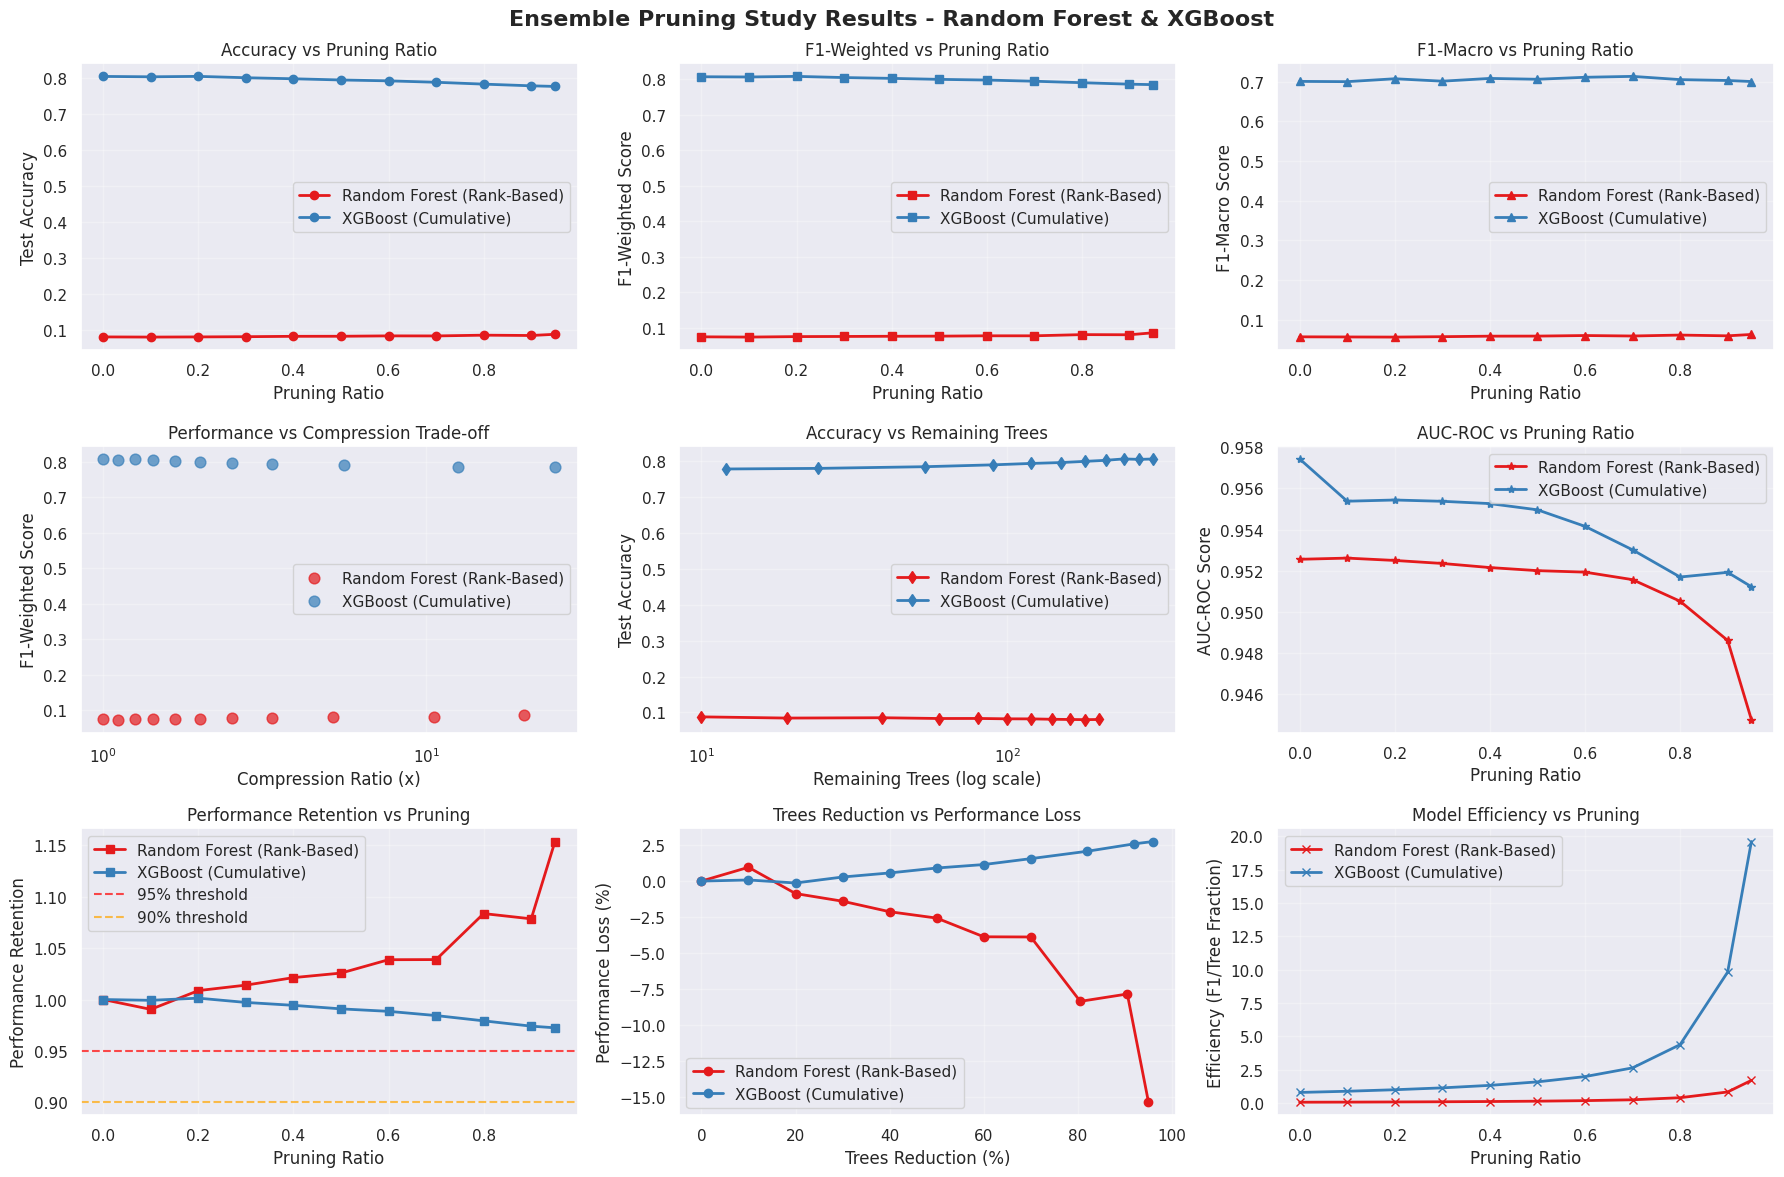


ENSEMBLE PRUNING STUDY - DETAILED REPORT
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning

Random Forest Results:
--------------------------------------------------
Model Type: Random Forest
Pruning Method: Rank-Based
Total Trees: 200
Baseline F1-Weighted: 0.0741
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 95.0%
  Trees: 10 / 200
  Compression: 20.0x
  F1_Weighted: 0.0855
  Performance loss: -15.4%

Maximum compression achieved: 20.0x

XGBoost Results:
--------------------------------------------------
Model Type: XGBoost
Pruning Method: Cumulative
Total Trees: 300
Baseline F1-Weighted: 0.8065
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 70.0%
  Trees: 90 / 300
  Compression: 3.3x
  F1_Weighted: 0.7939
  Performance loss: 1.6%

Maximum compression achieved: 25.0x

COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS
        Model     Method Pruning_Ratio Trees_Kept Trees_Reduct

,model_name,model_type,pruning_method,pruning_ratio,total_trees,remaining_trees,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,Random Forest,Random Forest,Rank-Based,0.00,200,200,1.000000,0.080547,0.074104,0.056915,0.952557,0.860049
1,Random Forest,Random Forest,Rank-Based,0.10,200,180,1.111111,0.080091,0.073392,0.056587,0.952614,0.860438
2,Random Forest,Random Forest,Rank-Based,0.20,200,160,1.250000,0.080547,0.074747,0.056284,0.952500,0.859874
3,Random Forest,Random Forest,Rank-Based,0.30,200,140,1.428571,0.081155,0.075142,0.057285,0.952354,0.859561
4,Random Forest,Random Forest,Rank-Based,0.40,200,120,1.666667,0.082219,0.075684,0.058596,0.952155,0.858927
5,Random Forest,Random Forest,Rank-Based,0.50,200,100,2.000000,0.082371,0.076012,0.058769,0.952005,0.858694
6,Random Forest,Random Forest,Rank-Based,0.60,200,80,2.500000,0.083435,0.076976,0.060197,0.951932,0.858350
7,Random Forest,Random Forest,Rank-Based,0.70,200,60,3.333333,0.083283,0.076986,0.059006,0.951568,0.857394
8,Random Forest,Random Forest,Rank-Based,0.80,200,39,5.128205,0.085410,0.080305,0.061357,0.950520,0.853921
9,Random Forest,Random Forest,Rank-Based,0.90,200,19,10.526316,0.084498,0.079926,0.059441,0.948616,0.848309


In [50]:
print("ENSEMBLE PRUNING ABLATION STUDY")
print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
print("="*100)

ensemble_pruning_study = EnsemblePruningAblationStudy()

pruning_ratios_ensemble = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

try:
    if 'tree' in gs_rf.best_estimator_.named_steps:
        rf_final_model = gs_rf.best_estimator_.named_steps['tree']
    else:
        raise ValueError("Random Forest model not found")

    print("Random Forest model extracted successfully")

    ensemble_pruning_study.run_rf_pruning_study(
        rf_model=rf_final_model,
        model_name='Random Forest',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with Random Forest model: {e}")

try:
    if 'xgb' in gs_xgb.best_estimator_.named_steps:
        xgb_final_model = gs_xgb.best_estimator_.named_steps['xgb']
    else:
        raise ValueError("XGBoost model not found")

    print("XGBoost model extracted successfully")

    ensemble_pruning_study.run_xgb_pruning_study(
        xgb_model=xgb_final_model,
        model_name='XGBoost',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with XGBoost model: {e}")

ensemble_pruning_study.plot_ensemble_pruning_results()
ensemble_pruning_study.generate_ensemble_pruning_report()

ensemble_results_df = pd.DataFrame(ensemble_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(ensemble_results_df)} rows")
print("\nPruning results:")
display(ensemble_results_df)

# Ablation Study Comparation

In [51]:
def compare_all_pruning_methods():
    """
    Compare pruning effectiveness across all model types
    """
    print("\n" + "="*120)
    print("COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS")
    print("="*120)

    # Collect data from both studies
    all_models_comparison = []

    # Neural network results
    for _, result in results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Neural Network',
                'Pruning_Method': 'L1 Norm',
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Components': f"{result['active_params']}/{result['total_params']}"
            })

    # Ensemble results
    for _, result in ensemble_results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            pruning_method = 'Rank-Based' if result['model_name'] == 'Random Forest' else 'Cumulative'
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Ensemble',
                'Pruning_Method': pruning_method,
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Trees': f"{result['remaining_trees']}/{result['total_trees']}"
            })

    if all_models_comparison:
        comparison_df = pd.DataFrame(all_models_comparison)

        # Create pivot table for better visualization
        pivot_accuracy = comparison_df.pivot_table(
            values='Accuracy_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_f1_weighted = comparison_df.pivot_table(
            values='F1_Weighted_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_roc = comparison_df.pivot_table(
            values='AUC_ROC_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_pr = comparison_df.pivot_table(
            values='AUC_PR_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )

        print("\nAccuracy Performance Across Pruning Levels:")
        print(pivot_accuracy.round(4))

        print("\nF1 Weighted Performance Across Pruning Levels:")
        print(pivot_f1_weighted.round(4))

        print("\nAUC_ROC Weighted Performance Across Pruning Levels:")
        print(pivot_auc_roc.round(4))

        print("\nAUC_PR Weighted Performance Across Pruning Levels:")
        print(pivot_auc_pr.round(4))

        pruning_levels = [0.3, 0.5, 0.7, 0.9]

        print(f"\n{'='*120}")
        print("PERFORMANCE RETENTION AT DIFFERENT PRUNING LEVELS")
        print("="*120)

        for pruning_level in pruning_levels:
            print(f"\n{'-'*60}")
            print(f"PERFORMANCE RETENTION AT {int(pruning_level*100)}% PRUNING")
            print(f"{'-'*60}")

            retention_summary = []
            for model in comparison_df['Model'].unique():
                model_data = comparison_df[comparison_df['Model'] == model]
                baseline = model_data[model_data['Pruning_Ratio'] == 0.0]
                pruned = model_data[model_data['Pruning_Ratio'] == pruning_level]

                if len(baseline) > 0 and len(pruned) > 0:
                    baseline_acc = baseline.iloc[0]['Accuracy_Test']
                    pruned_acc = pruned.iloc[0]['Accuracy_Test']
                    retention = pruned_acc / baseline_acc if baseline_acc != 0 else 0

                    retention_summary.append({
                        'Model': model,
                        'Type': baseline.iloc[0]['Type'],
                        'Method': baseline.iloc[0]['Pruning_Method'],
                        'Baseline_Accuracy': baseline_acc,
                        'Pruned_Accuracy': pruned_acc,
                        'Retention': retention,
                        'Compression': pruned.iloc[0]['Compression']
                    })

            if retention_summary:
                retention_df = pd.DataFrame(retention_summary).sort_values('Retention', ascending=False)
                print(retention_df.round(4))

            best_model = retention_df.iloc[0]
            print(f"\nBEST PRUNING METHOD AT {int(pruning_level*100)}% LEVEL:")
            print(f"Model: {best_model['Model']} ({best_model['Type']})")
            print(f"Method: {best_model['Method']}")
            print(f"Performance Retention: {best_model['Retention']:.1%}")
            print(f"Compression Achieved: {best_model['Compression']:.1f}x")

    else:
        print("No pruning results available for comparison.")

# Run comprehensive comparison
compare_all_pruning_methods()

print("\n" + "="*120)
print("ABLATION STUDY COMPLETE")


COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS

Accuracy Performance Across Pruning Levels:
Pruning_Ratio                                   0.0     0.3     0.5     0.7  \
Model         Type           Pruning_Method                                   
KAN           Neural Network L1 Norm         0.7839  0.7850  0.7746  0.7661   
MLP           Neural Network L1 Norm         0.7609  0.7653  0.7603  0.7128   
Random Forest Ensemble       Rank-Based      0.0805  0.0812  0.0824  0.0833   
XGBoost       Ensemble       Cumulative      0.8052  0.8015  0.7953  0.7889   

Pruning_Ratio                                   0.9  
Model         Type           Pruning_Method          
KAN           Neural Network L1 Norm         0.7030  
MLP           Neural Network L1 Norm         0.7094  
Random Forest Ensemble       Rank-Based      0.0845  
XGBoost       Ensemble       Cumulative      0.7790  

F1 Weighted Performance Across Pruning Levels:
Pruning_Ratio                        